In [1]:
!pip install keras --upgrade

Requirement already up-to-date: keras in /home/carnd/anaconda3/lib/python3.5/site-packages
Requirement already up-to-date: theano in /home/carnd/anaconda3/lib/python3.5/site-packages (from keras)
Requirement already up-to-date: six in /home/carnd/anaconda3/lib/python3.5/site-packages (from keras)
Requirement already up-to-date: pyyaml in /home/carnd/anaconda3/lib/python3.5/site-packages (from keras)
Requirement already up-to-date: numpy>=1.9.1 in /home/carnd/anaconda3/lib/python3.5/site-packages (from theano->keras)
Requirement already up-to-date: scipy>=0.14 in /home/carnd/anaconda3/lib/python3.5/site-packages (from theano->keras)


In [57]:
from Constants import ROOT_DIR, \
    H5_DIR_FULLYCONNECTED_MULTIPLE_RELU,\
    H5_DIR_FULLYCONNECTED_MULTIPLE_ELU,\
    H5_DIR_COVNET_MULTIPLE_RELU,\
    H5_DIR_COVNET_MULTIPLE_ELU,\
    H5_DIR_COVNET_JUMP_SIGMA,\
    H5_DIR_COVNET_JUMP_MU,\
    H5_DIR_COVNET_LAMBDA,\
    H5_DIR_ENSEMBLING, \
    HISTORY_DIR_FEEDFORWARD_RELU

In [58]:
import numpy as np
import math
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pylab
import pandas as pd

from scipy import stats
from numpy import random as nrand

%matplotlib inline

# Optional:
import seaborn as sns
sns.set(style="white", font_scale=1.6)

In [59]:
import tensorflow as tf
import keras
from keras.models import Model, Sequential, model_from_json, load_model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, LSTM, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D, Conv2D, Input
from keras.optimizers import Adam
from keras.utils import np_utils
from keras import backend as K
from keras.layers.core import Reshape

In [60]:
from Merton_Jump_Diffusion_SDE_Utilities import \
    ModelParameters, \
    random_model_params, \
    geometric_brownian_motion_jump_diffusion_log_returns
    
from Models import \
    fullyconnected_multiple_output, \
    fullyconnected_single_output, \
    covnet_multiple_8_layers, \
    covnet_single_ReLUs_6_layers, \
    r2

In [61]:
def test_set_model_params():
    return ModelParameters(
        all_time=2000,
        all_delta=0.00396825396,
        all_sigma = 0.1,
        gbm_mu = 0.05,
        jumps_sigma=0.07,
        jumps_mu=0.05,
        jumps_lamda=0.02)

def standard_convolutional_test_set(sample_size = 1000, dim = (40, 50)):
    test_set = []
    for i in range(sample_size):
        if (i%100 == 0):
            print(i)
        test_set.append(geometric_brownian_motion_jump_diffusion_log_returns(test_set_model_params()))

    test_set_pred = np.reshape(np.array(test_set), (sample_size, dim[0], dim[1], 1))
    return test_set_pred

def convolutional_batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_data = np.reshape(np.array(RETURNS_), (paramset_size*paths_p_paramset, 40, 50, 1))
        sigmas = np.array([[mp.all_sigma] for mp in PARAMS_])
        mus = np.array([[mp.gbm_mu] for mp in PARAMS_])
        jump_sigmas = np.array([[mp.jumps_sigma] for mp in PARAMS_])
        jump_mus = np.array([[mp.jumps_mu] for mp in PARAMS_])
        lambdas = np.array([[mp.lamda] for mp in PARAMS_])
        
        yield train_data, [sigmas, mus, jump_sigmas, jump_mus, lambdas]

def standard_fullyconnected_test_set(sample_size = 1000):
    test_set = []
    for i in range(sample_size):
        if (i%100 == 0):
            print(i)
        test_set.append(geometric_brownian_motion_jump_diffusion_log_returns(test_set_model_params()))

    train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in test_set]
    train_statistics = np.array([np.append(train_moments[i], 
                                  sm.tsa.stattools.acf(test_set[i])) 
                        for i in range(len(test_set))])
    return train_statistics

def standard_test_sets(sample_size = 1000, dim = (40, 50)):
    test_set = []
    for i in range(sample_size):
        if (i%100 == 0):
            print(i)
        test_set.append(geometric_brownian_motion_jump_diffusion_log_returns(test_set_model_params()))

    test_set_pred = np.reshape(np.array(test_set), (sample_size, dim[0], dim[1], 1))
    
    train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in test_set]
    train_statistics = np.array([np.append(train_moments[i], 
                                  sm.tsa.stattools.acf(test_set[i])) 
                        for i in range(len(test_set))])
    return test_set_pred, train_statistics

def fullyconnected_batch_generator(all_time = 2000, paramset_size = 32, paths_p_paramset = 5):
    while True:
        RETURNS_ = []
        PARAMS_ = []
        
        for i in range(paramset_size):
            mp = random_model_params()
            mp.all_time = all_time
            
            for j in range(paths_p_paramset):
                PARAMS_.append(mp)
                RETURNS_.append(geometric_brownian_motion_jump_diffusion_log_returns(mp))
        
        train_moments = [np.append(stats.moment(example, moment = range(2,20)), np.mean(example)) for example in RETURNS_]

        train_statistics = np.array([np.append(train_moments[i], 
                              sm.tsa.stattools.acf(RETURNS_[i])) 
                    for i in range(len(RETURNS_))])
        
        sigmas = np.array([[mp.all_sigma] for mp in PARAMS_])
        mus = np.array([[mp.gbm_mu] for mp in PARAMS_])
        jump_sigmas = np.array([[mp.jumps_sigma] for mp in PARAMS_])
        jump_mus = np.array([[mp.jumps_mu] for mp in PARAMS_])
        lambdas = np.array([[mp.lamda] for mp in PARAMS_])
        
        yield train_statistics, [sigmas, mus, jump_sigmas, jump_mus, lambdas]

In [62]:
def predictions_hist(predictions, true_value, plot_title = "model", param_name = "param", min_edge = None, max_edge = None, y_lim = (None, None), bin_size = 0.0025, img_subdir = "/Images/", save_to_file = True):
    
    if min_edge == None:
        min_edge = np.min(predictions)
    
    if max_edge == None:
        max_edge = np.max(predictions)
    
    bin_size = (max_edge-min_edge)/75
    N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
    bin_list = np.linspace(min_edge, max_edge, Nplus1)

    fig, ax = plt.subplots()
    plt.hist(predictions, bins=bin_list, animated = True)
    #pylab.title(plot_title);
    plt.axvline(x = true_value, c='k')
    plt.xlim(min_edge, max_edge)
    
    if y_lim != (None, None):
        plt.ylim(y_lim[0], y_lim[1])
        
    fig.set_dpi(120)
    if save_to_file:
        fig.savefig(ROOT_DIR + img_subdir + plot_title + "_" + param_name + ".png")
    return fig

# Informative Figures

A realisation of the Merton-Jump-Diffusion process

In [123]:
def merton_jump_diffusion_path_with_params(params, random_seed = False, seed = 1234):
    
    if random_seed:
        nrand.seed(None)
        random.seed(None)
    else:
        nrand.seed(seed)
        random.seed(seed)
        
    return_set = np.exp(geometric_brownian_motion_jump_diffusion_log_returns(params))
    path = [1]
    for i in range(len(return_set)):
        path.append(path[i]*return_set[i])
    return(path)

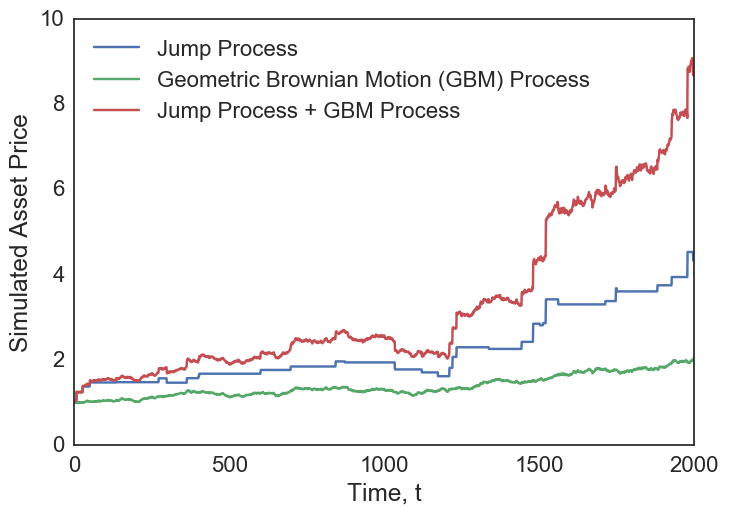

In [134]:
mp_jumps_only = test_set_model_params()
mp_jumps_only.gbm_mu = 0
mp_jumps_only.all_sigma = 0

mp_no_jumps = test_set_model_params()
mp_no_jumps.lamda = 0.00000000000001

mp = test_set_model_params()

plt.plot(merton_jump_diffusion_path_with_params(mp_jumps_only), label = "Jump Process")
plt.plot(merton_jump_diffusion_path_with_params(mp_no_jumps), label = "Geometric Brownian Motion (GBM) Process")
plt.plot(merton_jump_diffusion_path_with_params(mp), label = "Jump Process + GBM Process")
plt.legend(loc = 0)
plt.ylabel("Simulated Asset Price")
plt.xlabel("Time, t")
plt.savefig("../Images/Parameter-Effects/Merton_JD_Components.png")

0.1 0.05 0.07 0.02


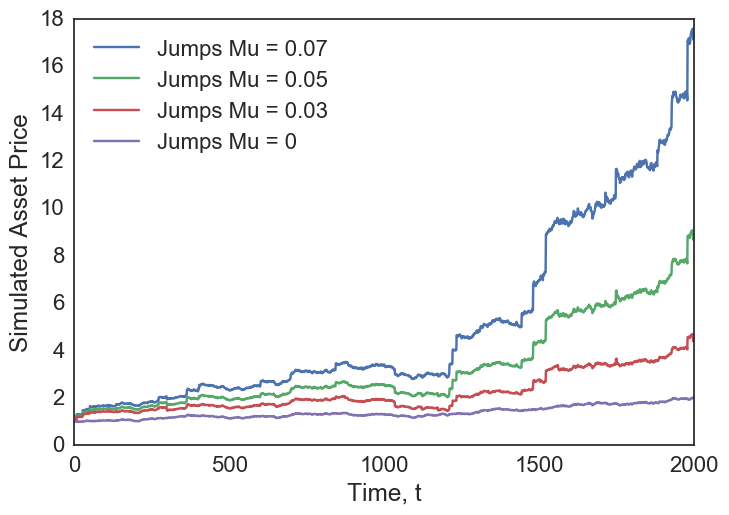

In [147]:
mp_no_jumps = test_set_model_params()
mp_no_jumps.jumps_mu = 0.0
mp_no_jumps.lamda = 0.00000000000000001

mp_vfew_jumps = test_set_model_params()
mp_vfew_jumps.jumps_mu = 0.03

mp_few_jumps = test_set_model_params()
mp_few_jumps.jumps_mu = 0.05

mp_many_jumps = test_set_model_params()
mp_many_jumps.jumps_mu = 0.07

plt.plot(merton_jump_diffusion_path_with_params(mp_many_jumps), label = "Jumps Mu = "+str(mp_many_jumps.jumps_mu))
plt.plot(merton_jump_diffusion_path_with_params(mp_few_jumps), label = "Jumps Mu = "+str(mp_few_jumps.jumps_mu))
plt.plot(merton_jump_diffusion_path_with_params(mp_vfew_jumps), label = "Jumps Mu = "+str(mp_vfew_jumps.jumps_mu))
plt.plot(merton_jump_diffusion_path_with_params(mp_no_jumps), label = "Jumps Mu = 0")
plt.legend(loc = 0)
plt.ylabel("Simulated Asset Price")
plt.xlabel("Time, t")
plt.savefig("../Images/Parameter-Effects/Effects_Jumps_Mu.png")
print(mp_many_jumps.all_sigma, mp_many_jumps.gbm_mu, mp_many_jumps.jumps_sigma, mp_many_jumps.lamda)

0.1 0.05 0.07 0.05


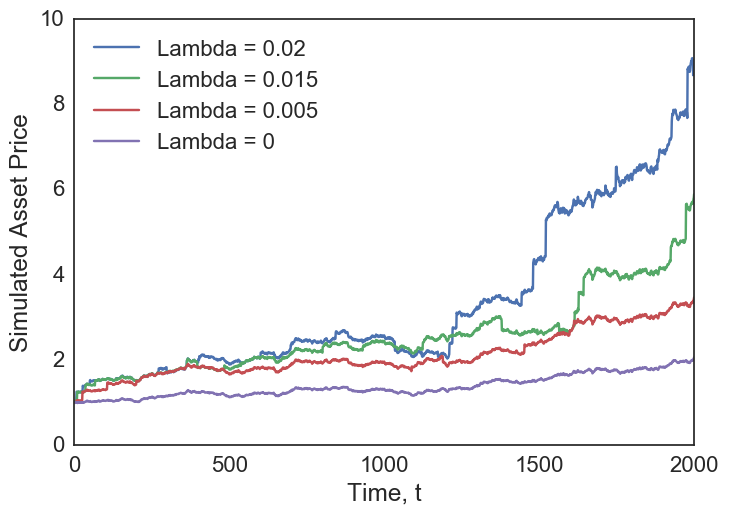

In [145]:
mp_no_jumps = test_set_model_params()
mp_no_jumps.lamda = 0.00000000000001

mp_vfew_jumps = test_set_model_params()
mp_vfew_jumps.lamda = 0.005

mp_few_jumps = test_set_model_params()
mp_few_jumps.lamda = 0.015

mp_many_jumps = test_set_model_params()
mp_many_jumps.lamda = 0.02

plt.plot(merton_jump_diffusion_path_with_params(mp_many_jumps), label = "Lambda = "+str(mp_many_jumps.lamda))
plt.plot(merton_jump_diffusion_path_with_params(mp_few_jumps), label = "Lambda = "+str(mp_few_jumps.lamda))
plt.plot(merton_jump_diffusion_path_with_params(mp_vfew_jumps), label = "Lambda = "+str(mp_vfew_jumps.lamda))
plt.plot(merton_jump_diffusion_path_with_params(mp_no_jumps), label = "Lambda = 0")
plt.legend(loc = 0)
plt.ylabel("Simulated Asset Price")
plt.xlabel("Time, t")
plt.savefig("../Images/Parameter-Effects/Effects_Lambda.png")

print(mp_many_jumps.all_sigma, mp_many_jumps.gbm_mu, mp_many_jumps.jumps_sigma, mp_many_jumps.jumps_mu)

0.1 0.02 0.07 0.05


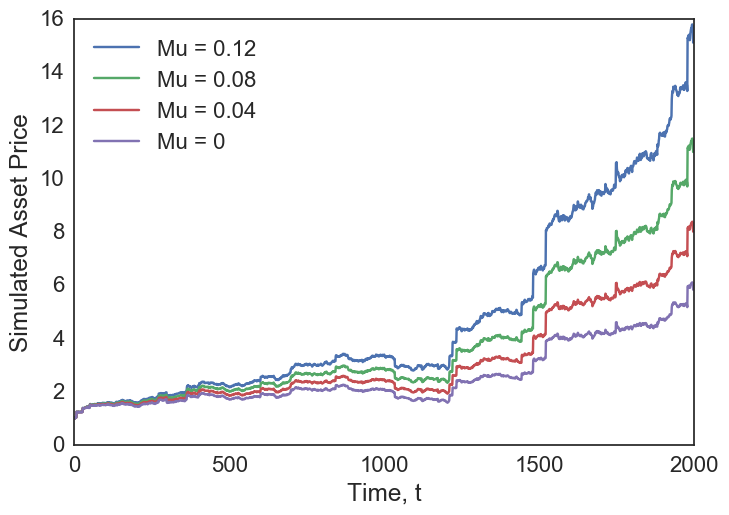

In [141]:
mp_no_jumps = test_set_model_params()
mp_no_jumps.gbm_mu = 0.0

mp_vfew_jumps = test_set_model_params()
mp_vfew_jumps.gbm_mu = 0.04

mp_few_jumps = test_set_model_params()
mp_few_jumps.gbm_mu = 0.08

mp_many_jumps = test_set_model_params()
mp_many_jumps.gbm_mu = 0.12

plt.plot(merton_jump_diffusion_path_with_params(mp_many_jumps), label = "Mu = "+str(mp_many_jumps.gbm_mu))
plt.plot(merton_jump_diffusion_path_with_params(mp_few_jumps), label = "Mu = "+str(mp_few_jumps.gbm_mu))
plt.plot(merton_jump_diffusion_path_with_params(mp_vfew_jumps), label = "Mu = "+str(mp_vfew_jumps.gbm_mu))
plt.plot(merton_jump_diffusion_path_with_params(mp_no_jumps), label = "Mu = 0")
plt.legend(loc = 0)
plt.ylabel("Simulated Asset Price")
plt.xlabel("Time, t")
plt.savefig("../Images/Parameter-Effects/Effects_Mu.png")

print(mp_many_jumps.all_sigma, mp_many_jumps.lamda, mp_many_jumps.jumps_sigma, mp_many_jumps.jumps_mu)

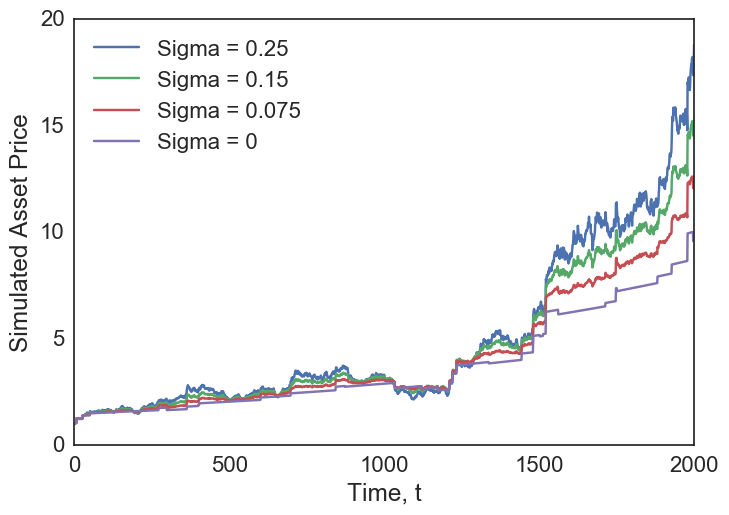

In [140]:
mp_no_jumps = test_set_model_params()
mp_no_jumps.all_sigma = 0.0
mp_no_jumps.gbm_mu = 0.1

mp_vfew_jumps = test_set_model_params()
mp_vfew_jumps.all_sigma = 0.075
mp_vfew_jumps.gbm_mu = 0.1

mp_few_jumps = test_set_model_params()
mp_few_jumps.all_sigma = 0.15
mp_few_jumps.gbm_mu = 0.1

mp_many_jumps = test_set_model_params()
mp_many_jumps.all_sigma = 0.25
mp_many_jumps.gbm_mu = 0.1

plt.plot(merton_jump_diffusion_path_with_params(mp_many_jumps), label = "Sigma = "+str(mp_many_jumps.all_sigma))
plt.plot(merton_jump_diffusion_path_with_params(mp_few_jumps), label = "Sigma = "+str(mp_few_jumps.all_sigma))
plt.plot(merton_jump_diffusion_path_with_params(mp_vfew_jumps), label = "Sigma = "+str(mp_vfew_jumps.all_sigma))
plt.plot(merton_jump_diffusion_path_with_params(mp_no_jumps), label = "Sigma = 0")
plt.legend(loc = 0)
plt.ylabel("Simulated Asset Price")
plt.xlabel("Time, t")
plt.savefig("../Images/Parameter-Effects/Effects_Sigma.png")

0.1 0.05 0.03 0.05


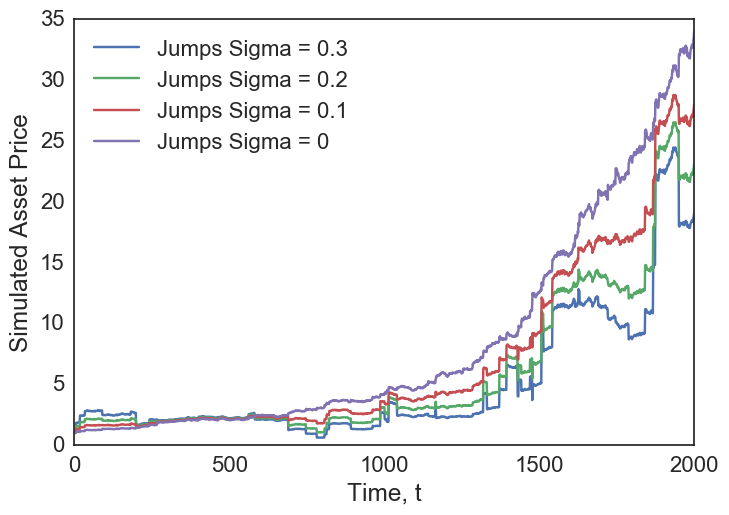

In [142]:
mp_no_jumps = test_set_model_params()
mp_no_jumps.jumps_sigma = 0.0
mp_no_jumps.lamda = 0.03

mp_vfew_jumps = test_set_model_params()
mp_vfew_jumps.jumps_sigma = 0.1
mp_vfew_jumps.lamda = 0.03

mp_few_jumps = test_set_model_params()
mp_few_jumps.jumps_sigma = 0.2
mp_few_jumps.lamda = 0.03

mp_many_jumps = test_set_model_params()
mp_many_jumps.jumps_sigma = 0.3
mp_many_jumps.lamda = 0.03

plt.plot(merton_jump_diffusion_path_with_params(mp_many_jumps), label = "Jumps Sigma = "+str(mp_many_jumps.jumps_sigma))
plt.plot(merton_jump_diffusion_path_with_params(mp_few_jumps), label = "Jumps Sigma = "+str(mp_few_jumps.jumps_sigma))
plt.plot(merton_jump_diffusion_path_with_params(mp_vfew_jumps), label = "Jumps Sigma = "+str(mp_vfew_jumps.jumps_sigma))
plt.plot(merton_jump_diffusion_path_with_params(mp_no_jumps), label = "Jumps Sigma = 0")
plt.legend(loc = 0)
plt.ylabel("Simulated Asset Price")
plt.xlabel("Time, t")
plt.savefig("../Images/Parameter-Effects/Effects_Jumps_Sigma.png")
print(mp_many_jumps.all_sigma, mp_many_jumps.gbm_mu, mp_many_jumps.lamda, mp_many_jumps.jumps_mu)

### Convolutional Architecture: Multiple Output

In [7]:
histories_elu = np.load("covnet_histories_elu.npy").tolist()
covnet_mo_elu_predictions = np.load("covnet_mo_elu_predictions.npy").tolist()

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


KeyboardInterrupt: 

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


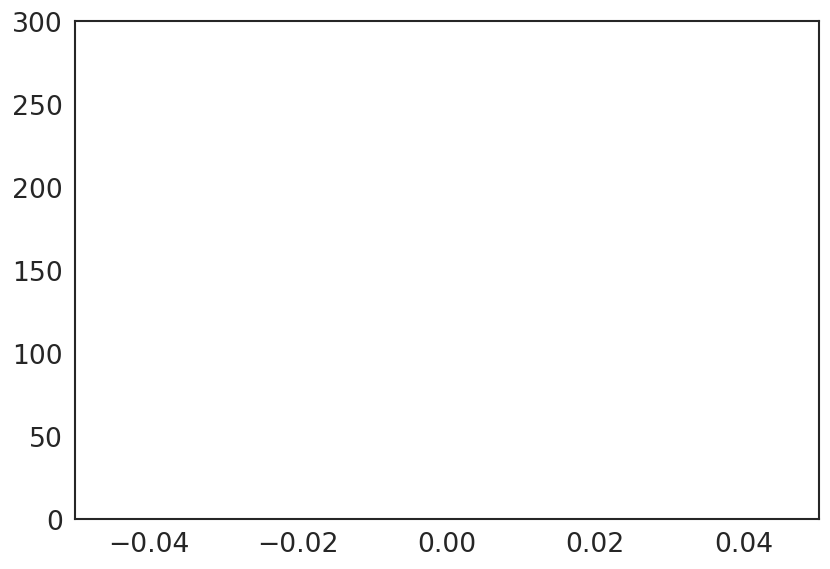

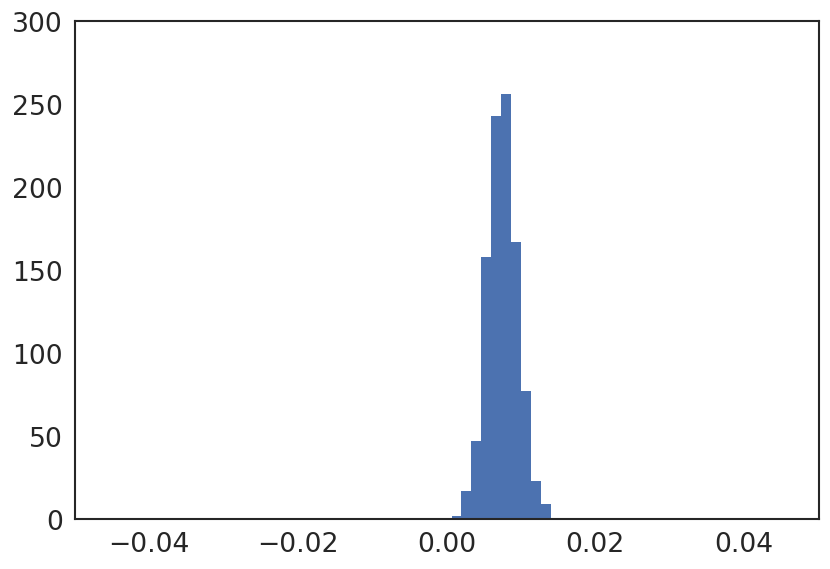

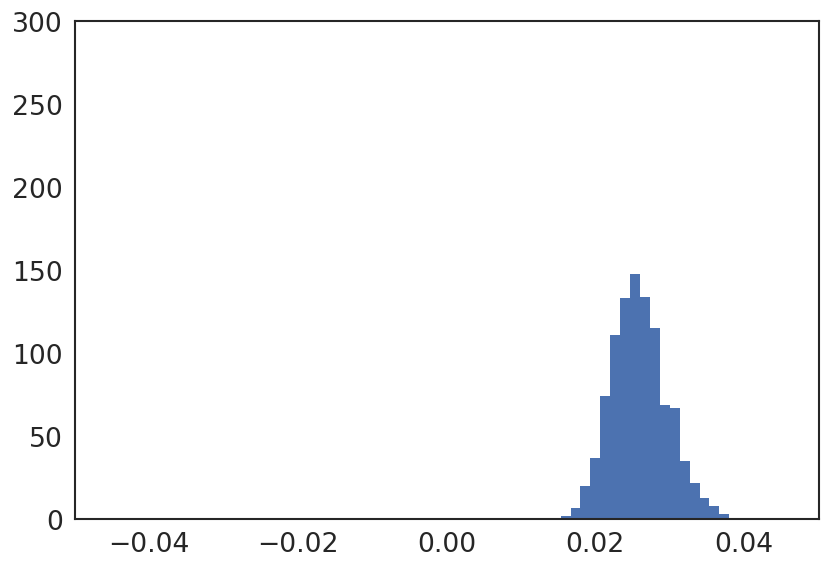

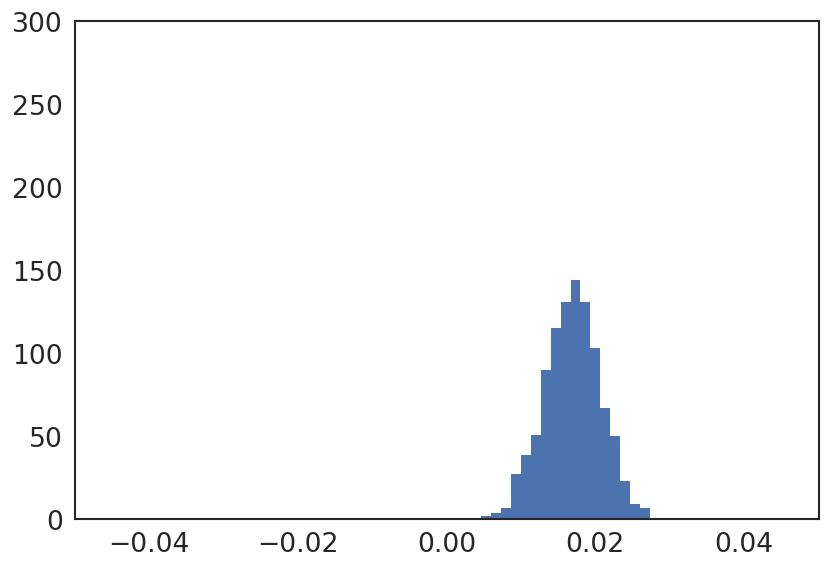

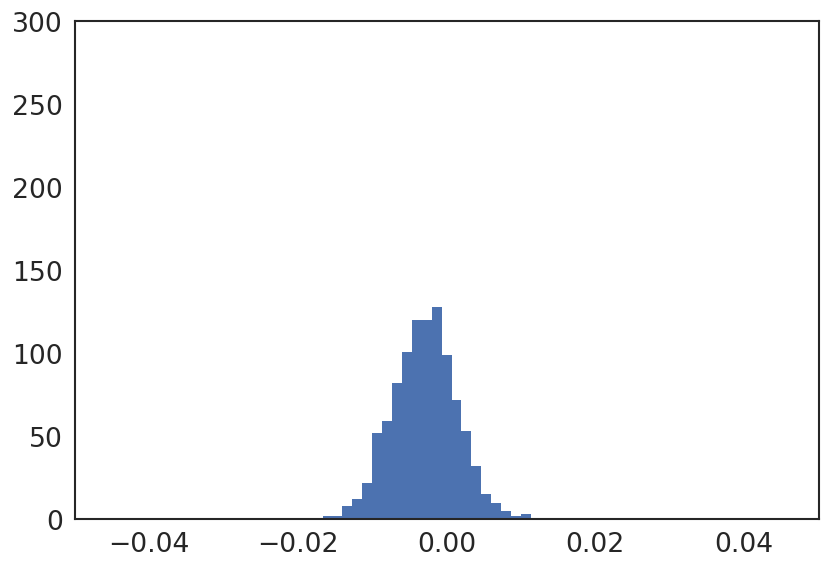

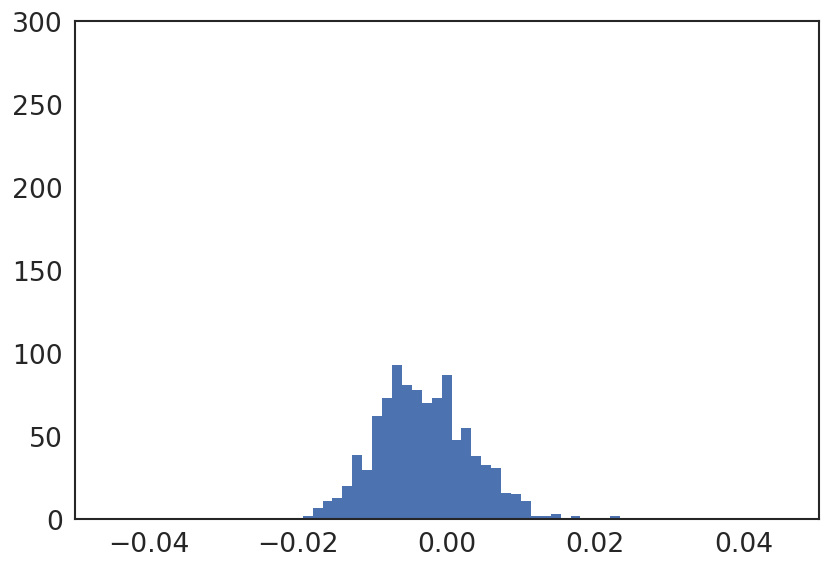

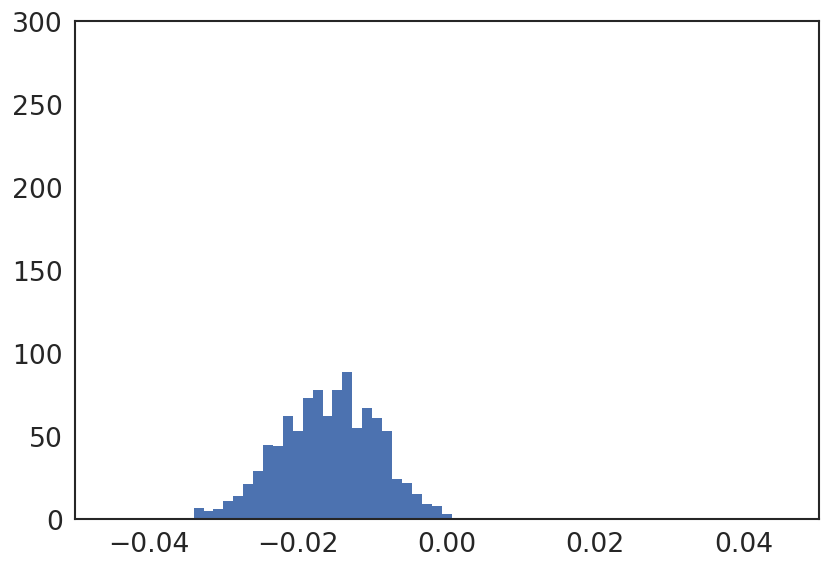

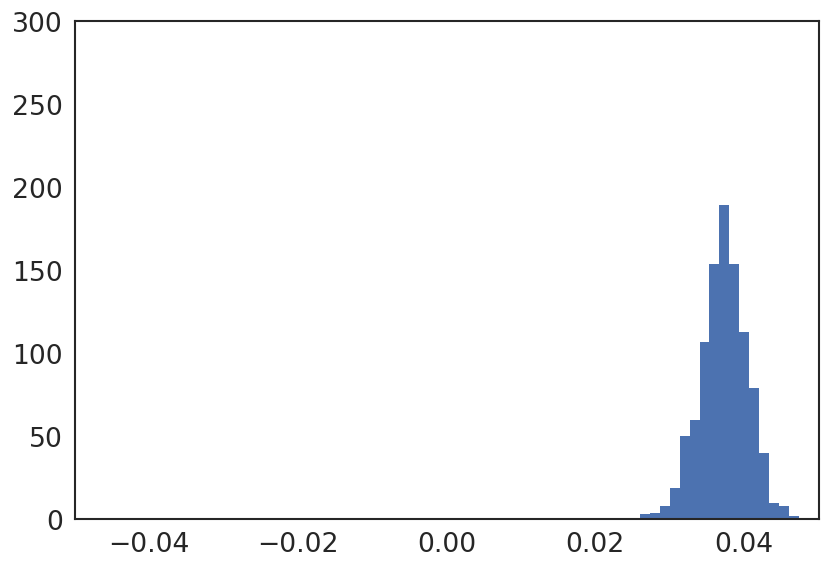

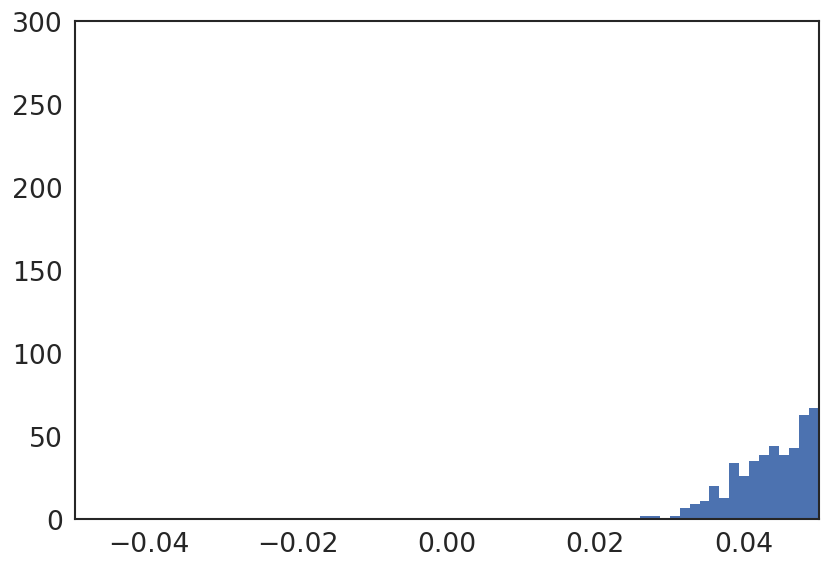

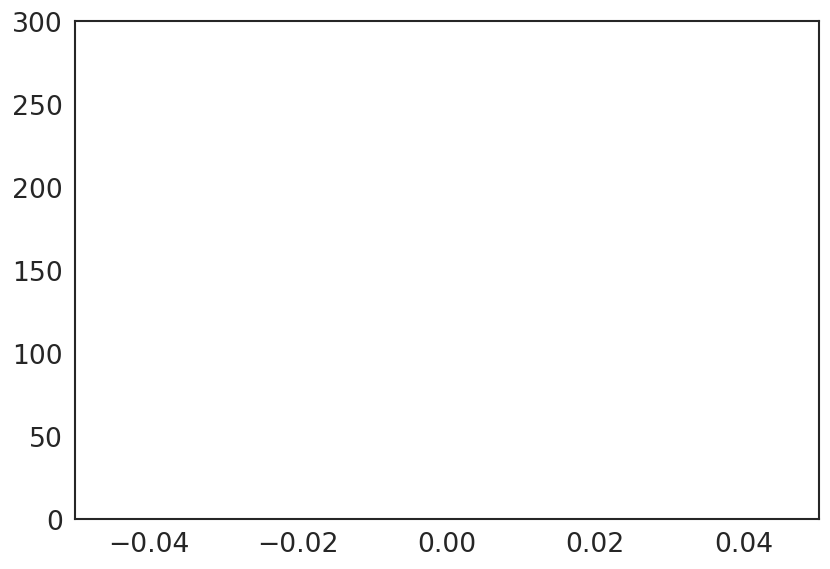

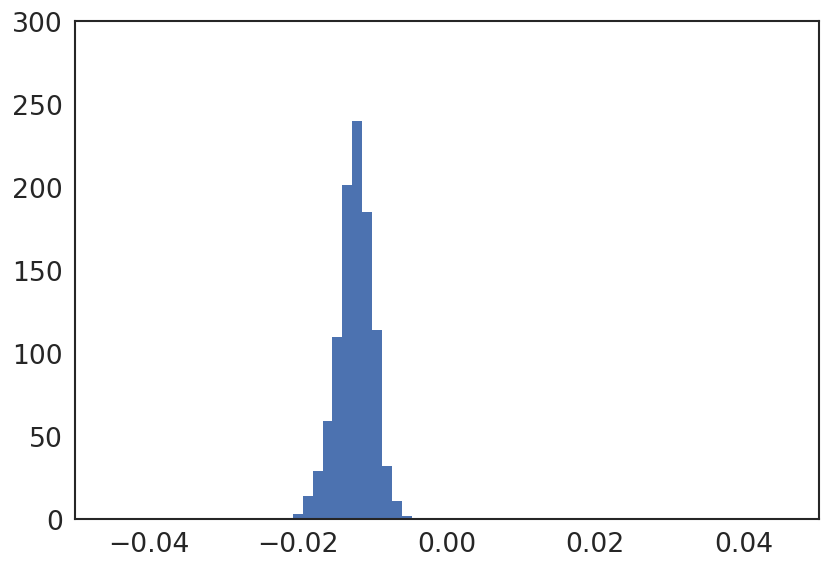

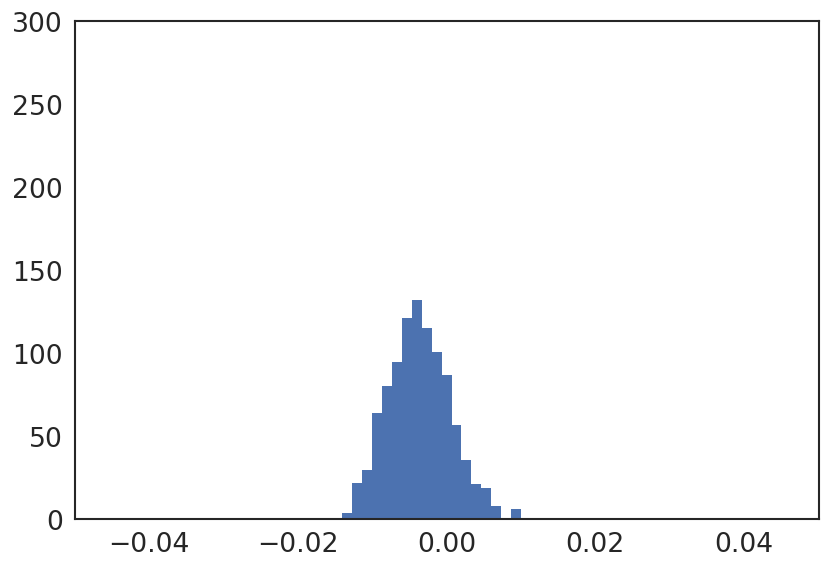

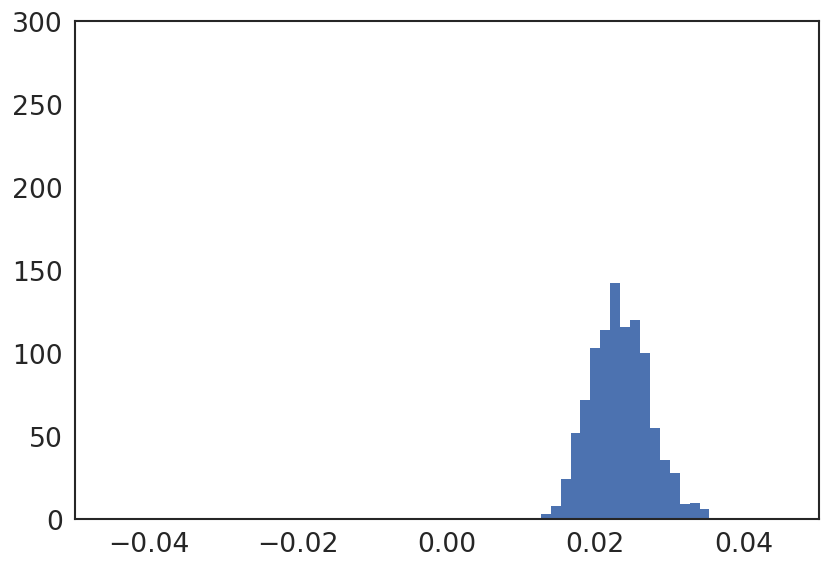

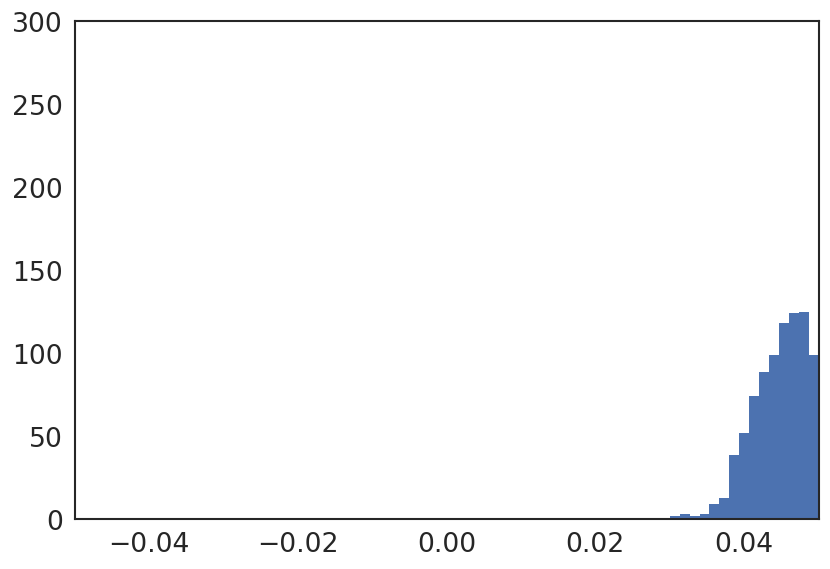

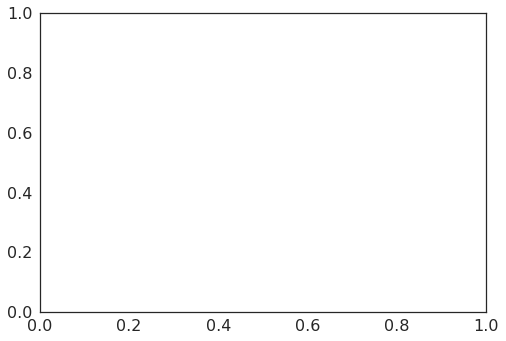

In [8]:
for prediction_elu in covnet_mo_elu_predictions:
    predictions_hist(np.reshape(prediction_elu[4], len(prediction_elu[3])), test_set_model_params().jumps_mu, 
                 "Convolutional Architecture - Multiple Output - ELU", 
                 "Jumps Mu",
                 min_edge = -0.05,
                 max_edge = 0.05,
                 y_lim = (0, 300),
                 save_to_file = False);

In [ ]:
i = 0
for prediction_elu in covnet_mo_elu_predictions:
    i=i+1
    print(i)
    predictions_hist(np.reshape(prediction_elu[1], len(prediction_elu[3])), test_set_model_params().gbm_mu, 
                 "Convolutional Architecture - Multiple Output - ELU", 
                 "Mu",
                 min_edge = -0.05,
                 max_edge = 0.15,
                 img_subdir = "Animations/Multiple_Output/Mu/"+str(i),
                 y_lim = (0, 300));

## Training / Convergence Graphs

In [41]:
def extract_history(histories, param_name = None):
    mape = []
    mse = []
    r2 = []
    
    r2_string = "r2"
    loss_string = "loss"
    mape_string = "mean_absolute_percentage_error"
    
    if param_name != None:
        r2_string = param_name + "_" + r2_string
        loss_string = param_name + "_" + loss_string
        mape_string = param_name + "_" + mape_string

    for history in histories:
        r2.append(history[r2_string])
        mse.append(history[loss_string])
        mape.append(history[mape_string])

    mape = np.reshape(mape, len(mape))
    r2 = np.reshape(r2, len(r2))
    mse = np.reshape(mse, len(mse))
    
    return mape, r2, mse

def plot_r2_versus_mse(r2, mse, epochs = None, savedir = None, xlim = None, r2_ylim = (-2, 1)):    
    fig, ax1 = plt.subplots()
    ax1.plot(r2, c='r')
    ax1.set_xlabel('Epochs')
    ax1.set_ylim(r2_ylim[0], r2_ylim[1])
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('R-Squared', color='r')
    ax1.tick_params('y', color='r')

    ax2 = ax1.twinx()
    ax2.plot(mse)
    ax2.set_ylabel('Mean Squared Error', color='b')
    ax2.set_yscale('log')
    ax2.tick_params('y', color='b')
    
    if xlim != None:
        ax1.set_xlim(xlim[0], xlim[1])
        ax2.set_xlim(xlim[0], xlim[1])
    
    if epochs != None:
        ax1.set_xlim(-10, epochs)

    fig.tight_layout()
    plt.show()
    
    if savedir != None:
        fig.savefig(ROOT_DIR + savedir + ".png")
        
    return fig

def standard_plot(data, xlabel = None, ylabel = None, xlim = None, ylim = None, yscale = None, savedir = None):
    fig = pylab.figure()

    pylab.plot(data);
    
    if xlim != None:
        pylab.xlim(xlim[0], xlim[1])
    
    if ylim != None:
        pylab.ylim(ylim[0], ylim[1]);
    
    if xlabel != None:
        pylab.xlabel(xlabel)
        
    if ylabel != None:
        pylab.ylabel(ylabel)
        
    if yscale != None:
        pylab.yscale(yscale)
        
    pylab.show();

    if savedir != None:
        fig.savefig(ROOT_DIR + savedir +".png")
        
    return fig

def all_training_history_plots(histories, modelname, paramname, xlim = None, r2_ylim = (-2, 1)):
    
    mape, r2, mse = histories

    r2_mse_fig = plot_r2_versus_mse(r2, mse, r2_ylim = r2_ylim, xlim = xlim,)

    r2_fig = standard_plot(r2, "Epochs", "R-Squared", 
                  ylim=r2_ylim, xlim = xlim,
                  savedir = "Images/Prediction-Convergence/"+modelname+"/"+paramname+"-RSquared");

    mse_fig = standard_plot(mse, "Epochs", "Mean Squared Error", yscale = 'log', xlim = xlim,
                  savedir = "Images/Prediction-Convergence/"+modelname+"/"+\
                  paramname+"-MSE");
    
    return r2_mse_fig, r2_fig, mse_fig

### Convolutional Architecture: Single Output

#### Lambda

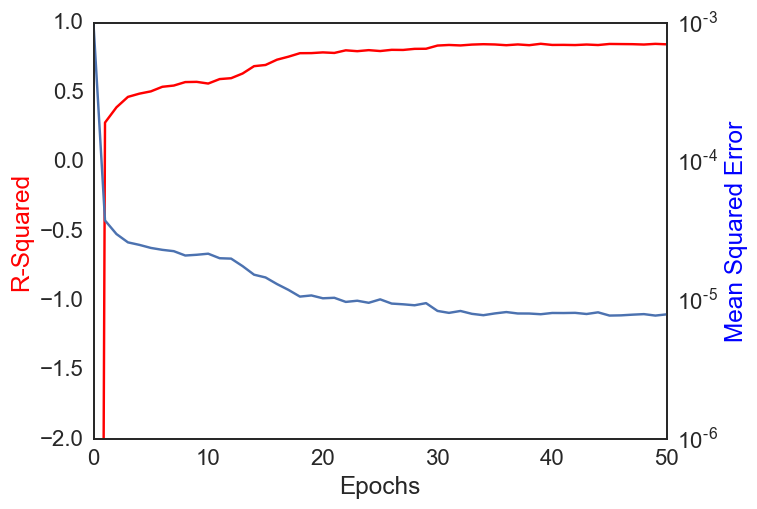

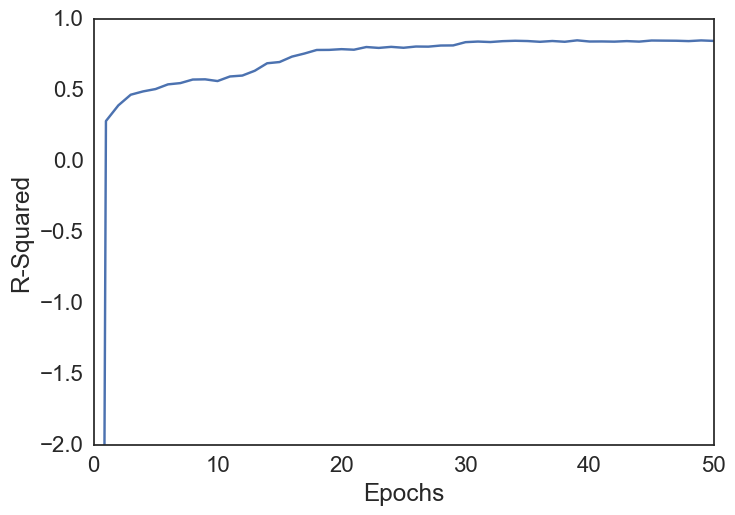

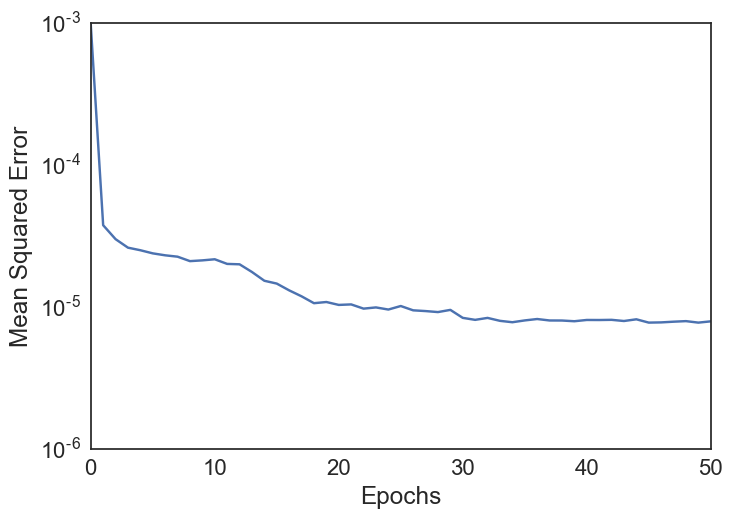

In [8]:
lambda_histories = extract_history(np.load("Lambda_histories.npy"))
all_training_history_plots(lambda_histories, 
                           "ConvolutionalNN-SingleOutput",
                           "Lambda");

#### Jumps Mu

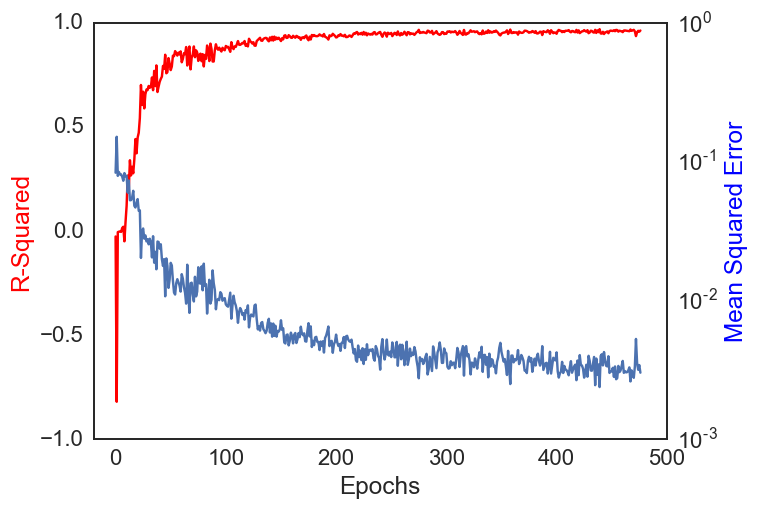

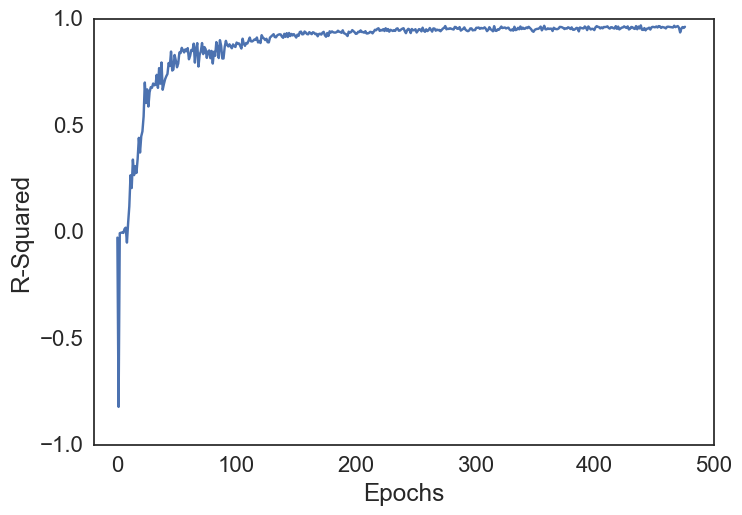

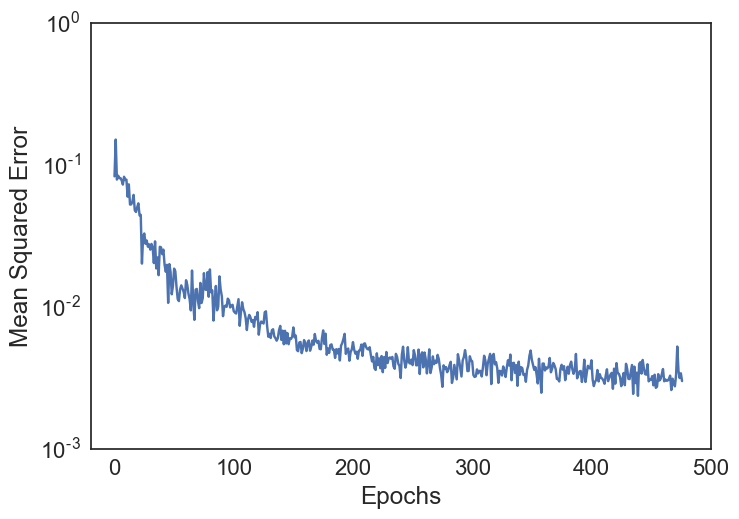

In [12]:
lambda_histories = extract_history(np.load("histories_covnet_jump_mu.npy"))
all_training_history_plots(lambda_histories, 
                           "ConvolutionalNN-SingleOutput",
                           "Lambda", r2_ylim = (-1, 1), xlim= (-20, 500));

#### Multiple Output Network

In [13]:
histories_elu = np.load("covnet_histories_elu.npy")

In [14]:
elu_histories_jump_mu = extract_history(np.load("covnet_histories_elu.npy"), 
                                "jump_mu")
elu_histories_jump_sigma = extract_history(np.load("covnet_histories_elu.npy"), 
                                "jump_sigma")
elu_histories_mu = extract_history(np.load("covnet_histories_elu.npy"), 
                                "mu")
elu_histories_sigma = extract_history(np.load("covnet_histories_elu.npy"), 
                                "sigma")
elu_histories_lambda = extract_history(np.load("covnet_histories_elu.npy"), 
                                "lambda")

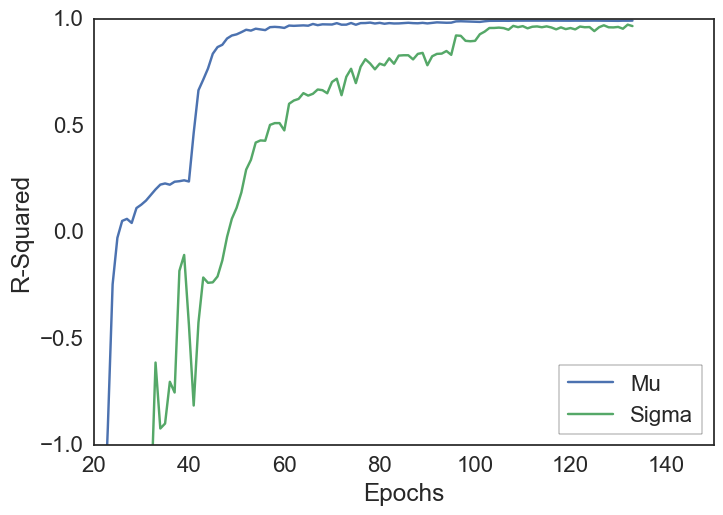

In [15]:
fig = plt.figure()
plt.plot(elu_histories_mu[1], label="Mu")
plt.plot(elu_histories_sigma[1], label="Sigma")
plt.ylim(-1, 1)
plt.xlim(20, 150)
plt.ylabel("R-Squared")
plt.xlabel("Epochs")
plt.legend(loc = 0, frameon=True)
fig.savefig("./Images/Prediction-Convergence/FullyConnectedNN-MultipleOutput-ELU/training_r2_values_mu_sigma.png")

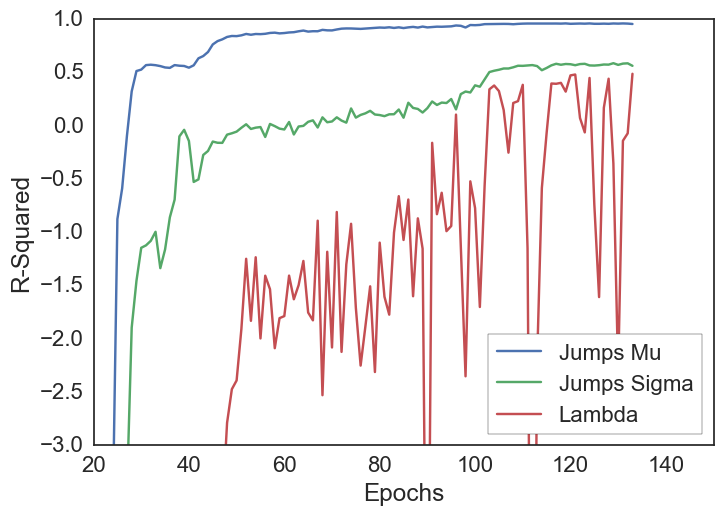

In [16]:
fig = plt.figure()
plt.plot(elu_histories_jump_mu[1], label="Jumps Mu")
plt.plot(elu_histories_jump_sigma[1], label="Jumps Sigma")
plt.plot(elu_histories_lambda[1], label="Lambda")
plt.ylim(-3, 1)
plt.xlim(20, 150)
plt.ylabel("R-Squared")
plt.xlabel("Epochs")
plt.legend(loc = 0, frameon=True)
fig.savefig("./Images/Prediction-Convergence/FullyConnectedNN-MultipleOutput-ELU/training_r2_values_jumps.png")

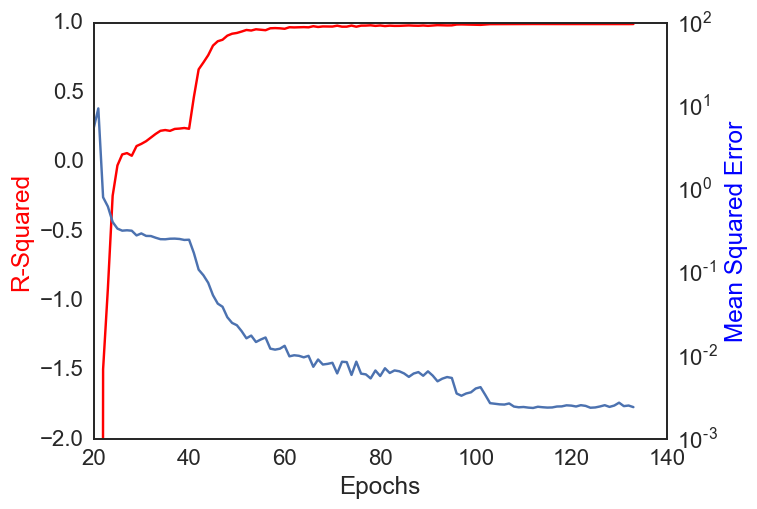

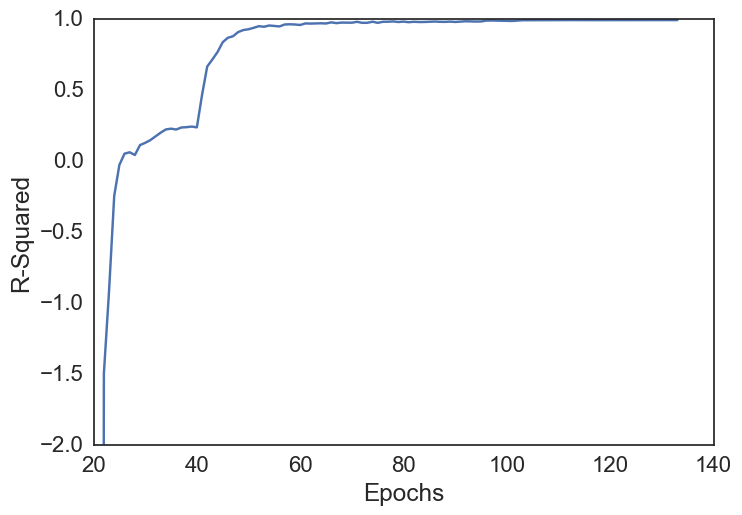

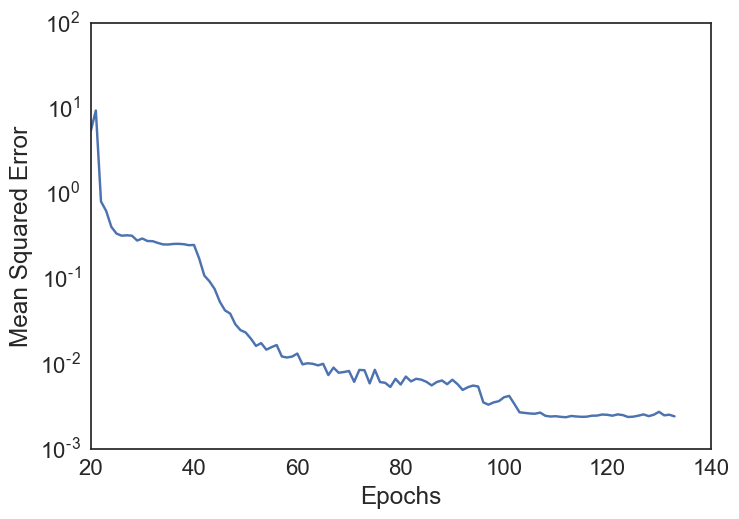

In [17]:
all_training_history_plots(elu_histories_mu, 
                           "ConvolutionalNN-MultipleOutput",
                           "Mu", r2_ylim = (-2, 1), xlim = (20, 140));

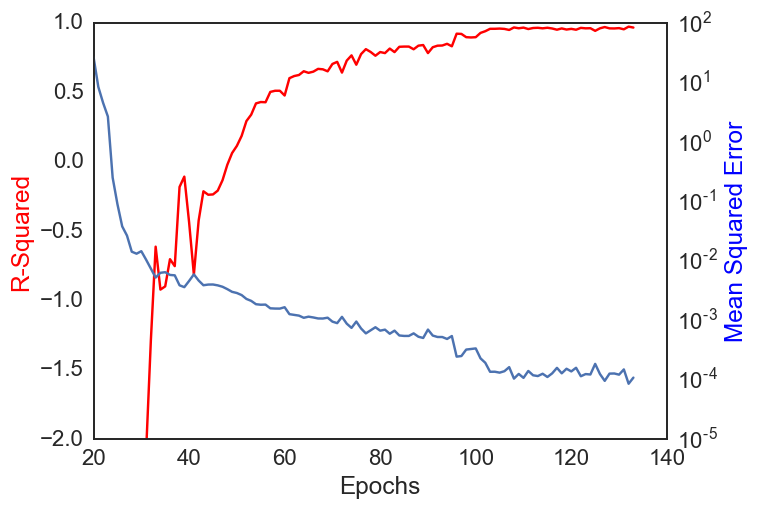

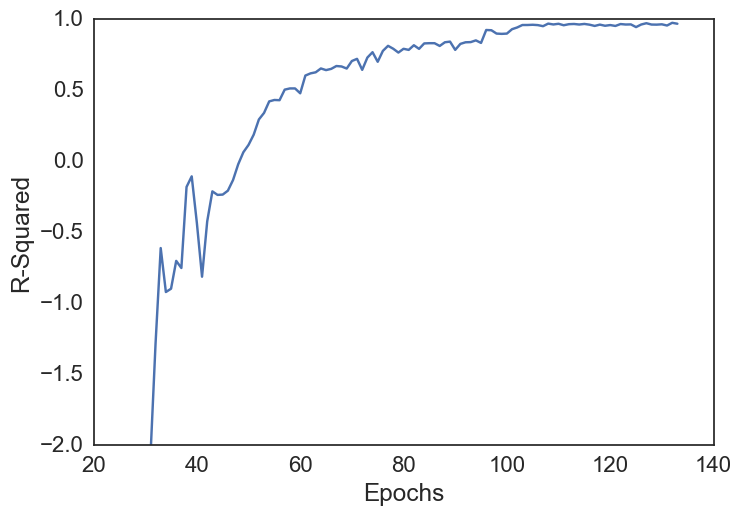

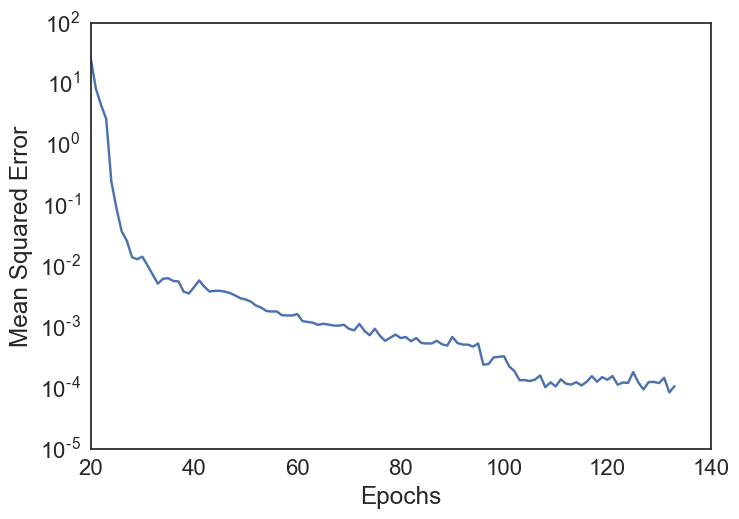

In [18]:
all_training_history_plots(elu_histories_sigma, 
                           "ConvolutionalNN-MultipleOutput",
                           "Sigma", r2_ylim = (-2, 1), xlim = (20, 140));

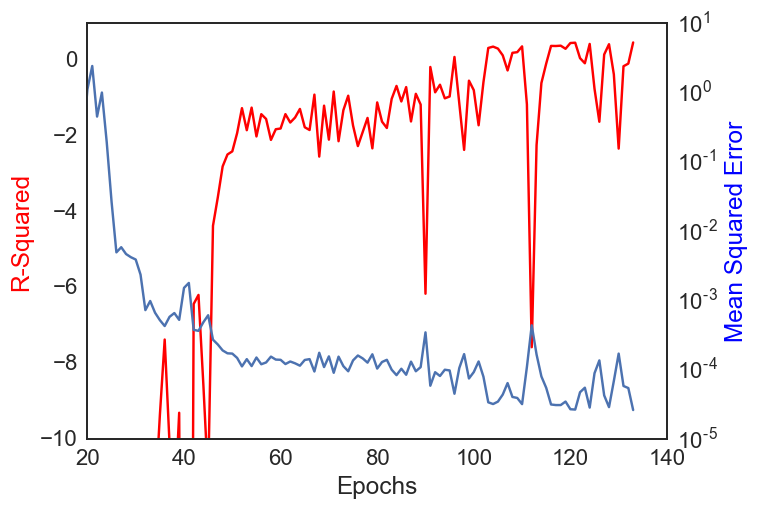

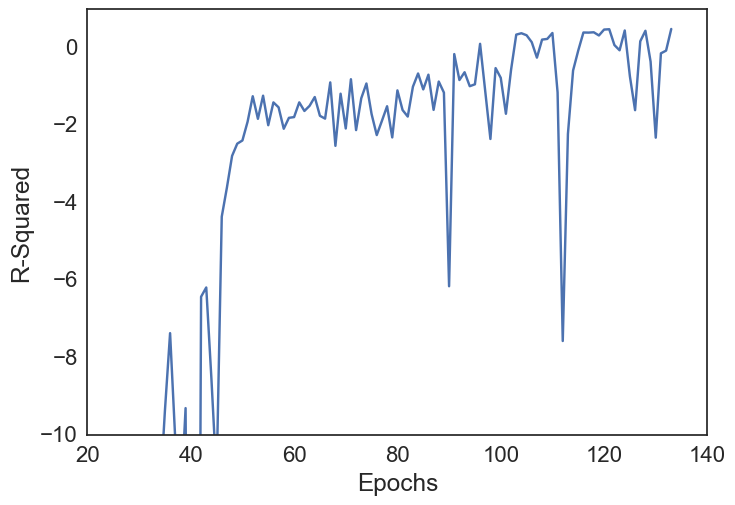

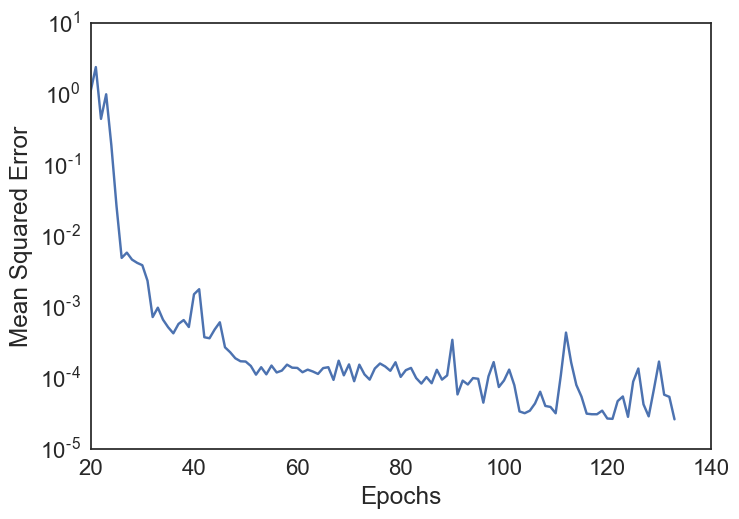

In [19]:
all_training_history_plots(elu_histories_lambda, 
                           "ConvolutionalNN-MultipleOutput",
                           "Lambda", r2_ylim = (-10, 1), xlim = (20, 140));

In [20]:
histories_ff = np.load("feedforward_relu_histories.npy")

In [21]:
elu_histories_jump_mu = extract_history(histories_ff,
                                "jump_mu")
elu_histories_jump_sigma = extract_history(histories_ff, 
                                "jump_sigma")
elu_histories_mu = extract_history(histories_ff, 
                                "mu")
elu_histories_sigma = extract_history(histories_ff, 
                                "sigma")
elu_histories_lambda = extract_history(histories_ff, 
                                "lambda")

(0, 70)

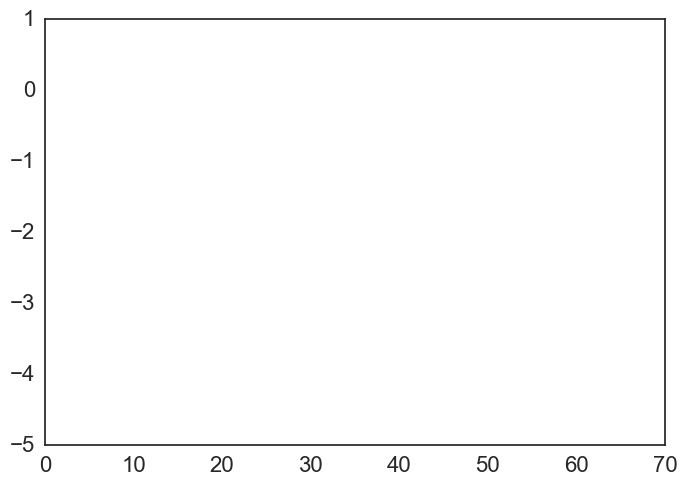

In [22]:
plt.figure()
plt.plot(elu_histories_jump_mu[1], label="Jumps Mu")
plt.plot(elu_histories_jump_sigma[1], label="Jumps Sigma")
plt.plot(elu_histories_mu[1], label="Mu")
plt.plot(elu_histories_sigma[1], label="Sigma")
plt.plot(elu_histories_lambda[1], label="Lambda")
plt.ylim(-5, 1)
plt.xlim(0, 70)

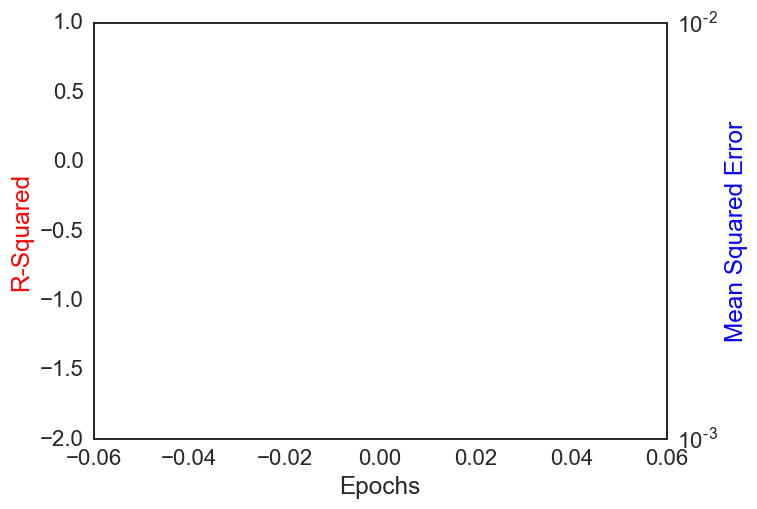

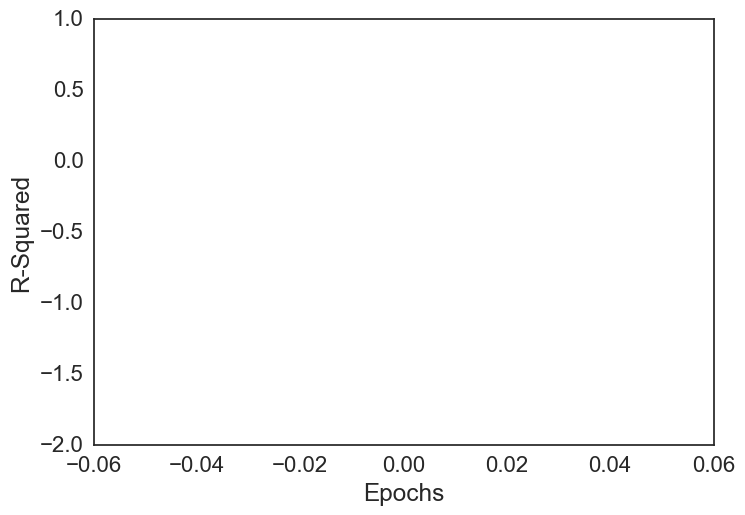

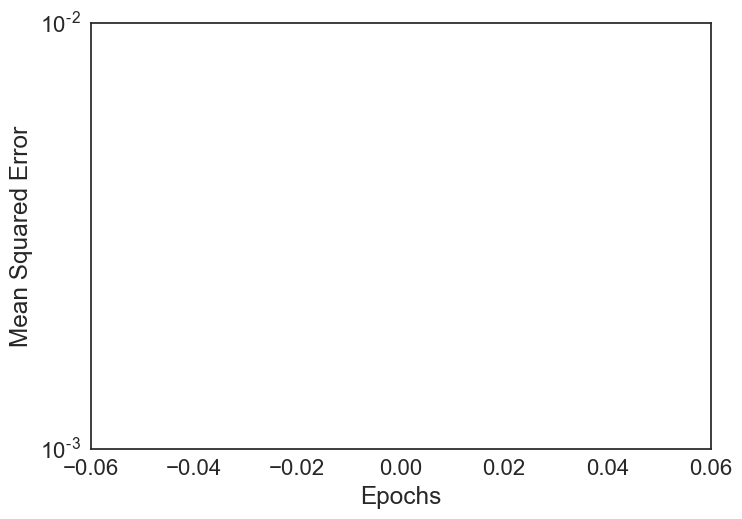

In [23]:
all_training_history_plots(elu_histories_sigma, 
                           "FullyConnectedNN-MultipleOutput-ELU",
                           "Sigma", r2_ylim = (-2, 1));

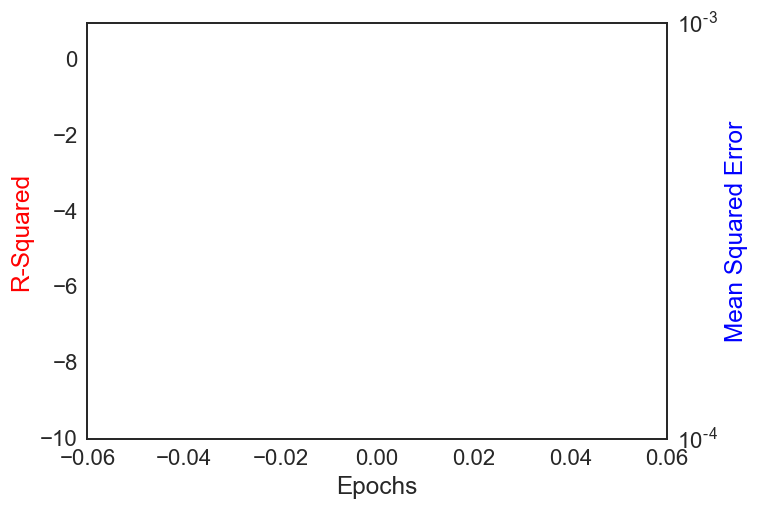

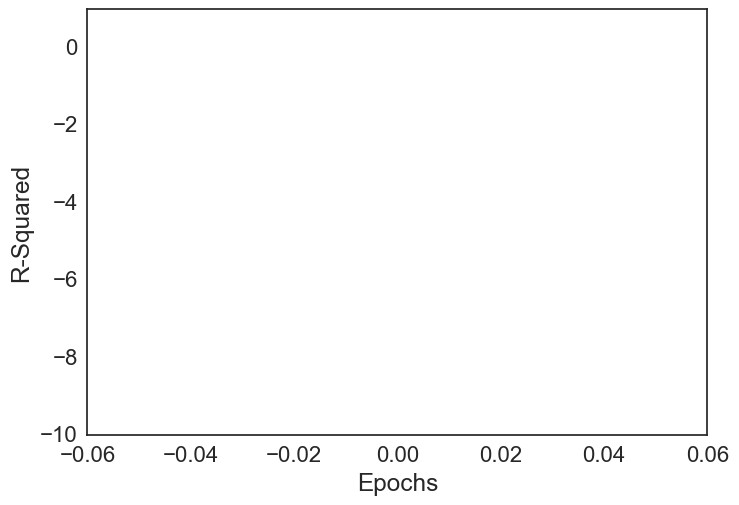

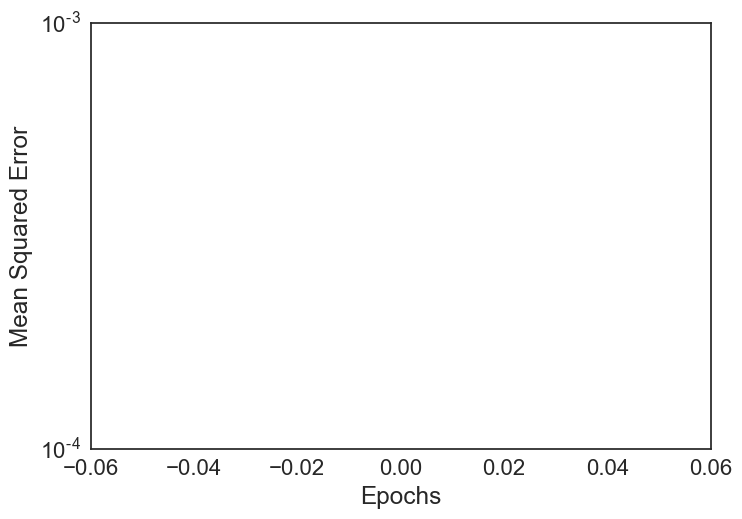

In [24]:
all_training_history_plots(elu_histories_lambda, 
                           "FullyConnectedNN-MultipleOutput-ELU",
                           "Lambda", r2_ylim = (-10, 1));

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


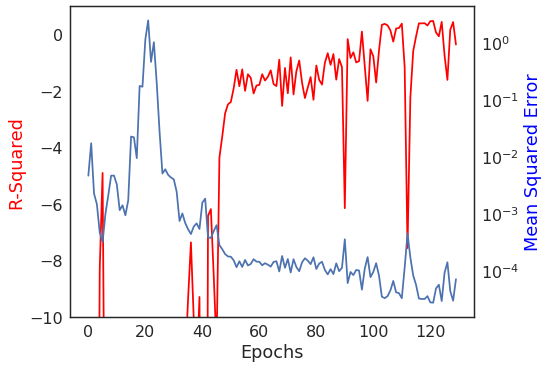

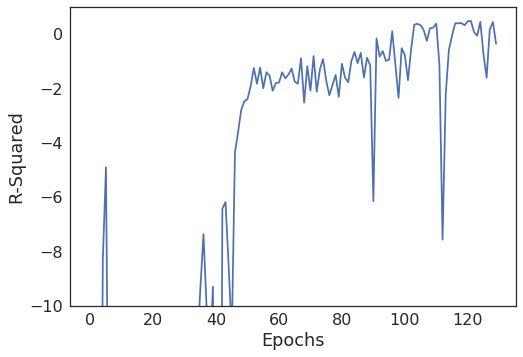

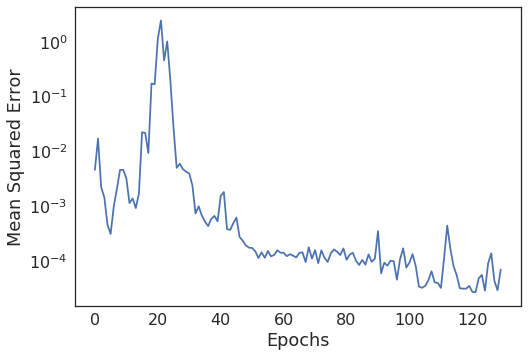

In [50]:
all_training_history_plots(elu_histories_lambda, 
                           "ConvolutionalNN-MultipleOutput",
                           "Lambda", r2_ylim = (-10, 1));

# Sensitivity Tests

## Multiple Output Model

### Mu

In [42]:
mu_s = []
preds_MEAN = []
preds_Lower_16 = []
preds_Upper_84 = []

preds_SINGLE_LAMBDA_MEAN = []
preds_SINGLE_LAMBDA_Lower_16 = []
preds_SINGLE_LAMBDA_Upper_84 = []

In [8]:
mp = test_set_model_params()

for j in range(100):
    covnet_mo_elu = covnet_multiple_ELUs_8_layers()
    covnet_mo_elu.load_weights(H5_DIR_COVNET_MULTIPLE_ELU)
    
    #covnet_lambda = covnet_single_lambda()
    #covnet_lambda.load_weights(H5_DIR_COVNET_LAMBDA)
    
    mp.gbm_mu = -1 + float(j)/50
    test_set = []
    
    print(j)
    
    print("GENERATION...")
    test_set_pred = standard_convolutional_test_set()
    
    print("PREDICTION...\n")
    predictions_elu = covnet_mo_elu.predict(test_set_pred)
    
    #predictions_lambda = covnet_lambda.predict(test_set_pred)
    
    print(np.transpose(np.mean(predictions_elu, axis = 1)))
    print("   sigma,       mu,      jump_sigma,   jump_mu,    lambda")
    print("    0.1         "+str(mp.gbm_mu)+"     0.07              0.05       0.02")
    
    preds_MEAN.append(np.mean(predictions_elu, axis = 1))
    mu_s.append(mp.gbm_mu)
    preds_Upper_84.append(np.percentile(predictions_elu, 84, axis = 1))
    preds_Lower_16.append(np.percentile(predictions_elu, 16, axis = 1))
    
np.save("Sensitivity_Test-Covnet_MO_Mu_preds_Upper_84.npy", preds_Upper_84)
np.save("Sensitivity_Test-Covnet_MO_Mu_preds_Lower_16.npy", preds_Lower_16)    
np.save("Sensitivity_Test-Covnet_MO_Mu_mu_s.npy", mu_s)
np.save("Sensitivity_Test-Covnet_MO_Mu_preds_MEAN.npy", preds_MEAN)

#np.save("Sensitivity_Test-preds_VaryingMu_SINGLE_LAMBDA_MEAN.npy", preds_SINGLE_LAMBDA_MEAN)
#np.save("Sensitivity_Test-preds_VaryingMu_preds_SINGLE_LAMBDA_Lower_16", preds_SINGLE_LAMBDA_Lower_16)
#np.save("Sensitivity_Test-preds_VaryingMu_preds_SINGLE_LAMBDA_Upper_84", preds_SINGLE_LAMBDA_Upper_84)

/home/carnd/Stochastic-Process-Calibration-Dissertation/Models.py:92: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  convnet_mo_elu = Model(input = input_1, output=[output1, output2, output3, output4, output5])


0
GENERATION...
0
100
200
300
400
500
600
700
800
900
PREDICTION...

[[ 0.09579758  0.06199436  0.07925735  0.06622556  0.01607951]]
   sigma,       mu,      jump_sigma,   jump_mu,    lambda
    0.1         -1.0     0.07              0.05       0.02
1
GENERATION...
0
100
200
300
400
500
600
700
800
900
PREDICTION...

[[ 0.09575898  0.06027672  0.07934583  0.06557428  0.01605073]]
   sigma,       mu,      jump_sigma,   jump_mu,    lambda
    0.1         -0.98     0.07              0.05       0.02
2
GENERATION...
0
100
200
300
400
500


KeyboardInterrupt: 

# Results 

In [12]:
test_set_pred, train_statistics = standard_test_sets()

0
100
200
300
400
500
600
700
800
900


In [65]:
covnet_mo_elu = load_model("./Models/FULLMODEL_10LAYERS_COVNET.h5", custom_objects={"r2":r2})
covnet_mu = load_model("./Models/covnet_mu.h5", custom_objects={"r2":r2})
covnet_sigma = load_model("./Models/covnet_sigma.h5", custom_objects={"r2":r2})
covnet_lambda = load_model("./Models/covnet_lambda.h5", custom_objects={"r2":r2})
covnet_jump_mu = load_model("./Models/covnet_jump_mu.h5", custom_objects={"r2":r2})
covnet_jump_sigma = load_model("./Models/covnet_jump_sigma.h5", custom_objects={"r2":r2})
#covnet_mo_elu = covnet_multiple_ELUs_8_layers()
#covnet_mo_elu.load_weights("./Model_weights/FULLMODEL_RELAXED_ELU_COVNET.h5")

In [9]:
feedforward = load_model("FULL_FEEDFORWARD_NETWORK2.h5", custom_objects={"r2":r2}) #fullyconnected_multiple_ReLUs()
#feedforward.load_weights("feedforward_running_gen_2_relu.h5")

In [66]:
df_mle = pd.read_csv("./Mongwe_Results/Wilson_MLE.csv")
df_mme = pd.read_csv("./Mongwe_Results/Wilson_MME.csv")
df_profiling = pd.read_csv("./Mongwe_Results/Wilson_Profiling.csv")
df_mle.head()

,Mu_0.05,Sigma_0.1,Lambda_0.02,Jumps_Mu_0.05,Jumps_Sigma_0.07
0,0.084534,0.100121,0.019912,0.033907,0.064079
1,0.121781,0.099913,0.021274,0.036169,0.065433
2,0.112126,0.101874,0.015141,0.038059,0.065111
3,0.052435,0.099358,0.022075,0.025310,0.063176
4,0.098594,0.100529,0.014173,0.034644,0.057960


In [67]:
#predictions = covnet_mo.predict(test_set_pred)
predictions_elu = covnet_mo_elu.predict(test_set_pred)
predictions_ff = feedforward.predict(train_statistics)

In [68]:
mp = test_set_model_params()

In [69]:
predictions_mu = covnet_mu.predict(test_set_pred)

/Users/Rayno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/Rayno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


NameError: name 'predictions_ff' is not defined

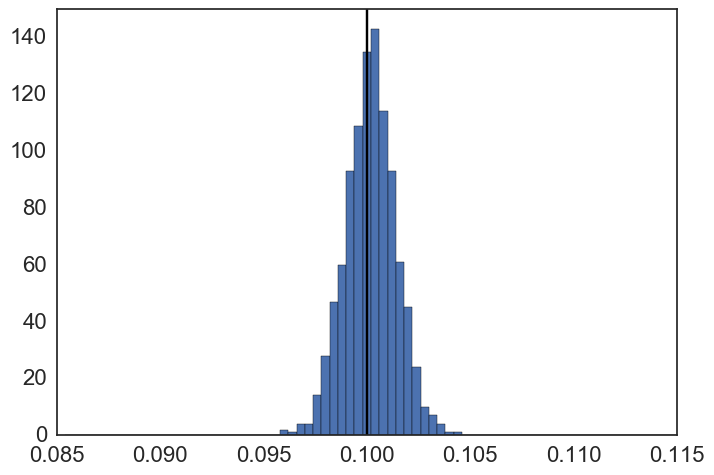

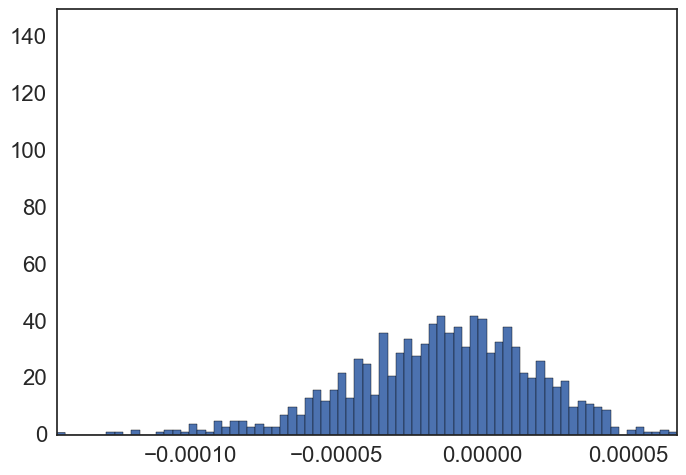

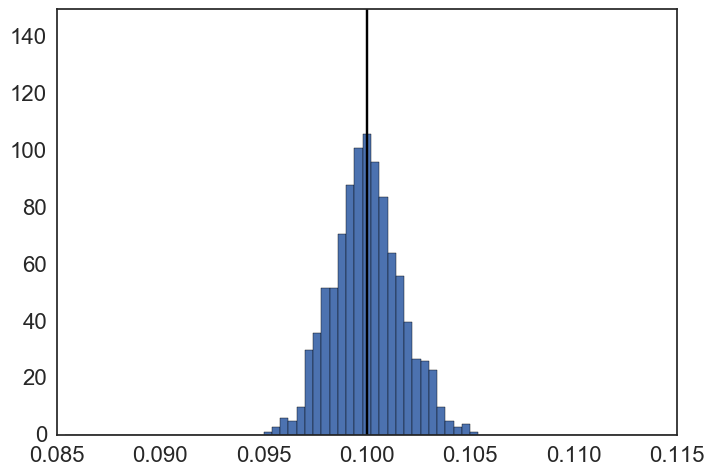

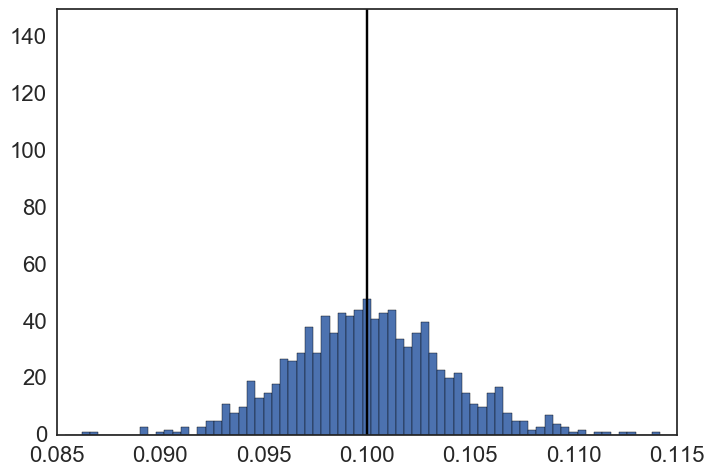

In [71]:
"""predictions_hist(predictions[0], mp.all_sigma, 
                 "Convolutional Architecture - Multiple Output - ReLU", 
                 "Sigma",
                 min_edge = 0.08,
                 max_edge = 0.155,
                 y_lim = (0, 210),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-MultipleOutput-ReLU/");
"""

predictions_hist(df_mle['Sigma_0.1'].as_matrix(), mp.all_sigma, 
                 "Maximum Likelihood Estimation", 
                 "Sigma",
                 min_edge = 0.085,
                 max_edge = 0.115,
                 y_lim = (0, 150),
                 img_subdir = "/Images/Parameter-Prediction-Results/MLE/");

predictions_hist(df_mme['Sigma_0.1'].as_matrix(), mp.all_sigma, 
                 "Generalised Method of Moments Estimation", 
                 "Sigma",
                 y_lim = (0, 150),
                 img_subdir = "/Images/Parameter-Prediction-Results/MME/");

predictions_hist(df_profiling['Sigma_0.1'].as_matrix(), mp.all_sigma, 
                 "Likelihood Profiling (Honore)", 
                 "Sigma",
                 min_edge = 0.085,
                 max_edge = 0.115,
                 y_lim = (0, 150),
                 img_subdir = "/Images/Parameter-Prediction-Results/Profiling/");

predictions_hist(predictions_elu[0], mp.all_sigma, 
                 "Convolutional Architecture - Multiple Output - ELU", 
                 "Sigma",
                 min_edge = 0.085,
                 max_edge = 0.115,
                 y_lim = (0, 150),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-MultipleOutput-ELU/");

predictions_hist(predictions_ff[0], mp.all_sigma, 
                 "Fully Connected Architecture - Multiple Output - ELU", 
                 "Sigma",
                 min_edge = 0.085,
                 max_edge = 0.115,
                 y_lim = (0, 120),
                 img_subdir = "/Images/Parameter-Prediction-Results/FullyConnected-MultipleOutput-ELU/");

/Users/Rayno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


NameError: name 'predictions_elu' is not defined

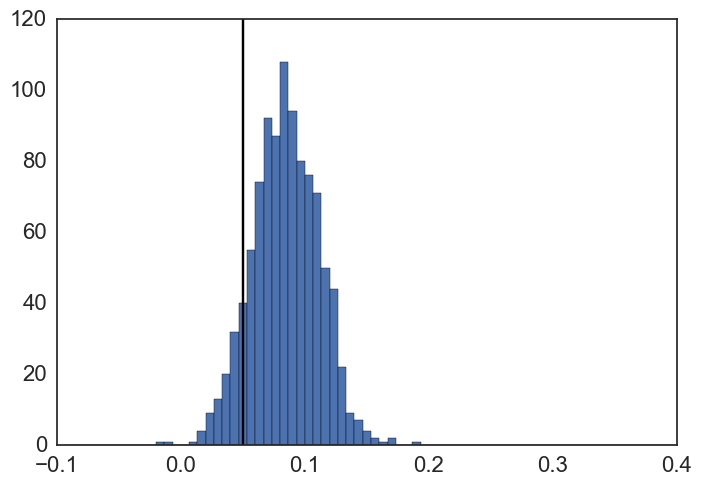

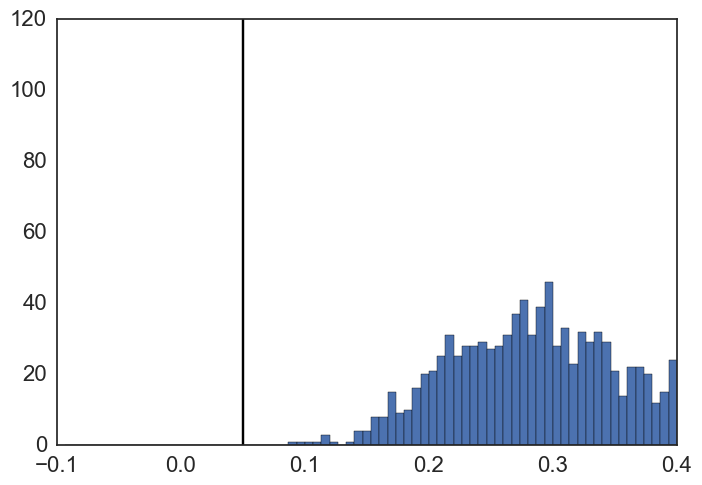

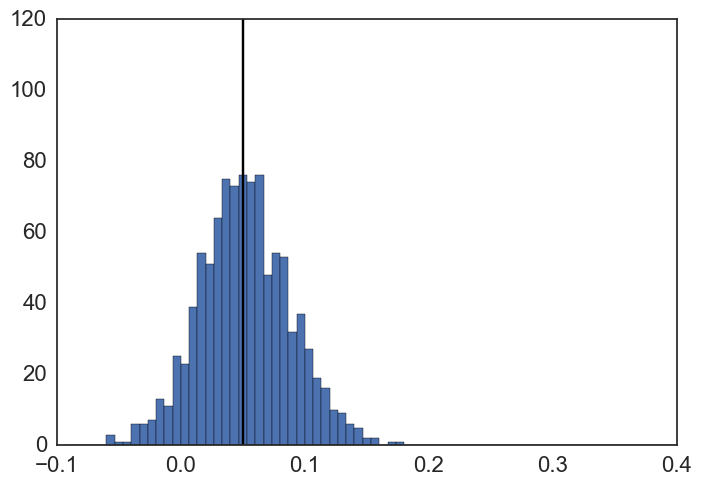

In [53]:
"""predictions_hist(predictions[1], mp.gbm_mu, 
                 "Convolutional Architecture - Multiple Output - ReLU", 
                 "Mu",
                 min_edge = -0.1,
                 max_edge = 0.4,
                 y_lim = (0, 120),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-MultipleOutput-ReLU/");
"""

predictions_hist(df_mle['Mu_0.05'].as_matrix(), mp.gbm_mu, 
                 "Maximum Likelihood Estimation", 
                 "Mu",
                 min_edge = -0.1,
                 max_edge = 0.4,
                 y_lim = (0, 120),
                 img_subdir = "/Images/Parameter-Prediction-Results/MLE/");

predictions_hist(df_mme['Mu_0.05'].as_matrix(), mp.gbm_mu, 
                 "Generalised Method of Moments Estimation", 
                 "Mu",
                 min_edge = -0.1,
                 max_edge = 0.4,
                 y_lim = (0, 120),
                 img_subdir = "/Images/Parameter-Prediction-Results/MME/");

predictions_hist(df_profiling['Mu_0.05'].as_matrix(), mp.gbm_mu, 
                 "Likelihood Profiling (Honore)", 
                 "Mu",
                 min_edge = -0.1,
                 max_edge = 0.4,
                 y_lim = (0, 120),
                 img_subdir = "/Images/Parameter-Prediction-Results/Profiling/");

predictions_hist(predictions_elu[1], mp.gbm_mu, 
                 "Convolutional Architecture - Multiple Output - ELU", 
                 "Mu",
                 min_edge = -0.1,
                 max_edge = 0.4,
                 y_lim = (0, 120),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-MultipleOutput-ELU/");

predictions_hist(predictions_ff[1], mp.gbm_mu, 
                 "Fully Connected Architecture - Multiple Output - ELU", 
                 "Mu",
                 min_edge = -0.1,
                 max_edge = 0.4,
                 y_lim = (0, 120),
                 img_subdir = "/Images/Parameter-Prediction-Results/FullyConnected-MultipleOutput-ELU/");

In [ ]:
def r2(y_true, y_pred):
    """
    returns the correlation coefficient of y_pred against y_true.

    :param y_true: the true values (independent variable)
    :param y_pred: the predicted values (dependent variable)
    """
    
    SSE = K.sum(K.square(y_true-y_pred))
    SST = K.sum(K.square(y_true-K.mean(y_true)))
    
    return 1-SSE/SST


In [ ]:
#covnet_jump_sigma = load_model("./Model_Weights/covnet_jump_sigma_FULLMODEL.h5", compile=False)
#covnet_jump_sigma.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2, 'mean_absolute_percentage_error'])
covnet_jump_sigma = load_model("covnet_jump_sigma_FULLMODEL.h5", custom_objects={"r2":r2})
preds_so = covnet_jump_sigma.predict(test_set_pred)

/Users/Rayno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/Rayno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


NameError: name 'predictions_elu' is not defined

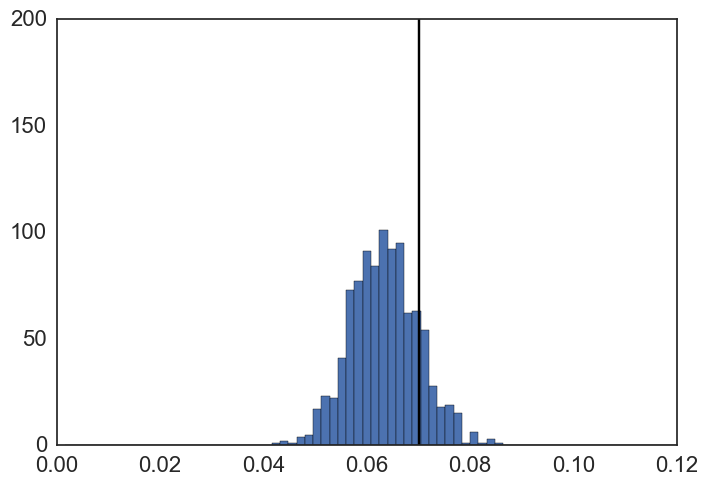

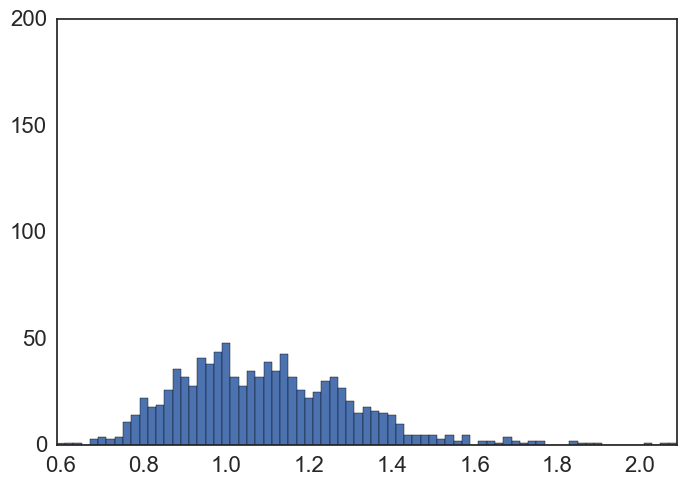

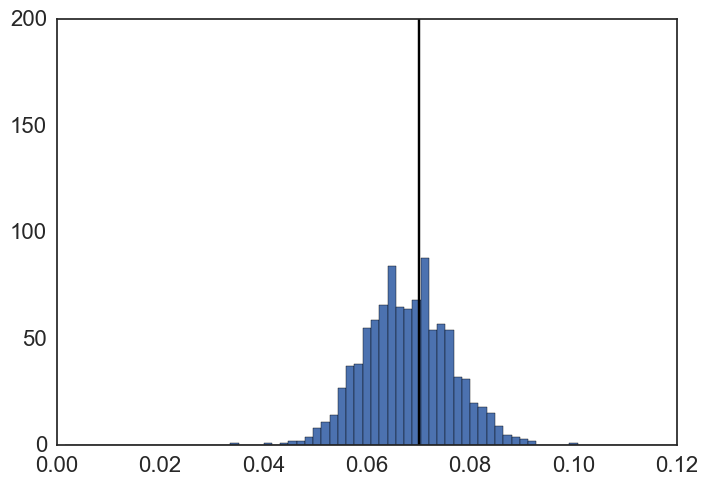

In [54]:
"""predictions_hist(predictions[2], mp.jumps_sigma, 
                 "Convolutional Architecture - Multiple Output - ReLU", 
                 "Jumps Sigma",
                 min_edge = 0.02,
                 max_edge = 0.13,
                 y_lim = (0, 80),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-MultipleOutput-ReLU/");
"""
y_lim = (0, 200)
max_edge = 0.12


predictions_hist(df_mle['Jumps_Sigma_0.07'].as_matrix(), mp.jumps_sigma, 
                 "Maximum Likelihood Estimation", 
                 "Jumps Sigma",
                 min_edge = 0.0,
                 max_edge = max_edge,
                 y_lim = y_lim,
                 img_subdir = "/Images/Parameter-Prediction-Results/MLE/");

predictions_hist(df_mme['Jumps_Sigma_0.07'].as_matrix(), mp.jumps_sigma, 
                 "Generalised Method of Moments Estimation", 
                 "Jumps Sigma",
                 y_lim = y_lim,
                 img_subdir = "/Images/Parameter-Prediction-Results/MME/");

predictions_hist(df_profiling['Jumps_Sigma_0.07'].as_matrix(), mp.jumps_sigma, 
                 "Likelihood Profiling (Honore)", 
                 "Jumps Sigma",
                 min_edge = 0.0,
                 max_edge = max_edge,
                 y_lim = y_lim,
                 img_subdir = "/Images/Parameter-Prediction-Results/Profiling/");

predictions_hist(predictions_elu[2], mp.jumps_sigma, 
                 "Convolutional Architecture - Multiple Output - ELU", 
                 "Jumps Sigma",
                 min_edge = 0.0,
                 max_edge = max_edge,
                 y_lim = y_lim,
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-MultipleOutput-ELU/");

predictions_hist(predictions_ff[2], mp.jumps_sigma, 
                 "Fully Connected Architecture - Multiple Output - ELU", 
                 "Jumps Sigma",
                 min_edge = 0.0,
                 max_edge = max_edge,
                 y_lim = y_lim,
                 img_subdir = "/Images/Parameter-Prediction-Results/FullyConnected-MultipleOutput-ELU/");

predictions_hist(preds_so, mp.jumps_sigma, 
                 "Convolutional Architecture - Single Output - ELU", 
                 "Jumps Sigma",
                 min_edge = 0.0,
                 max_edge = max_edge,
                 y_lim = y_lim,
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-SingleOutput/");

In [ ]:
covnet_jump_mu = load_model("covnet_jump_mu_FULLMODEL.h5", custom_objects={"r2":r2})#covnet_single_ReLUs_6_layers()
#covnet_jump_mu.load_weights("./Model_Weights/covnet_jump_mu_running.h5")
#covnet_jump_mu.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2, 'mean_absolute_percentage_error'])
preds_so_mu = covnet_jump_mu.predict(test_set_pred)

/Users/Rayno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


NameError: name 'predictions_elu' is not defined

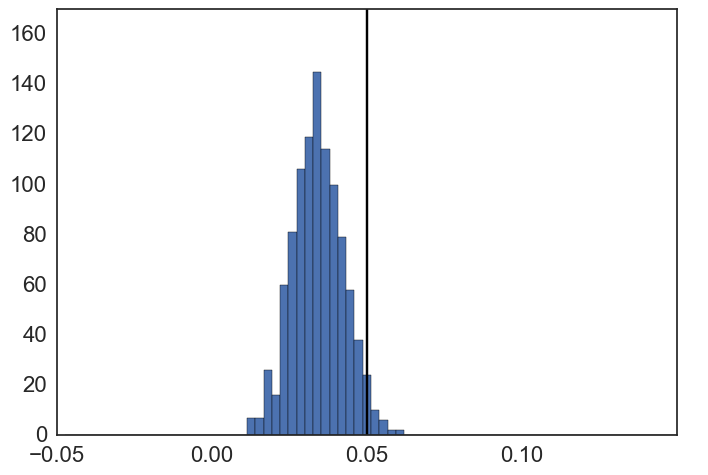

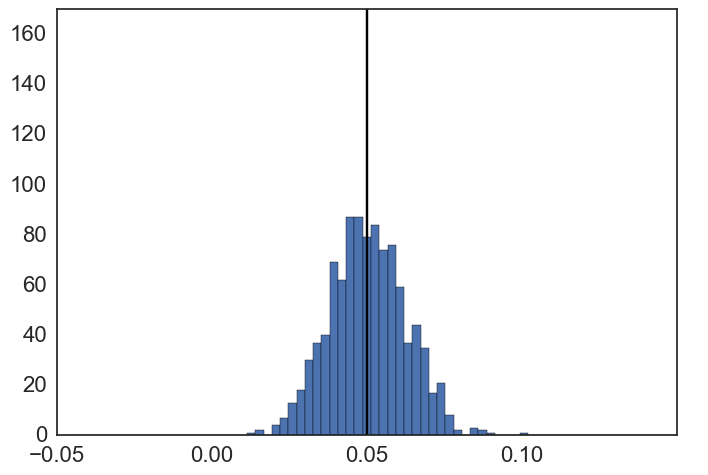

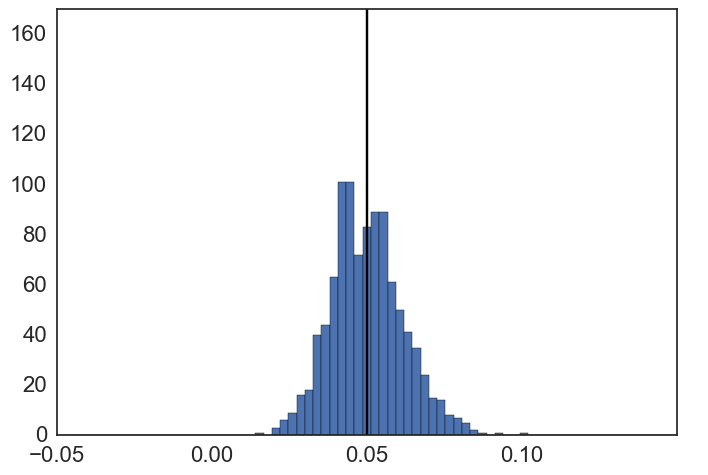

In [55]:
"""predictions_hist(predictions[3], mp.jumps_mu, 
                 "Convolutional Architecture - Multiple Output - ReLU", 
                 "Jumps Mu",
                 min_edge = -0.1,
                 max_edge = 0.15,
                 y_lim = (0, 120),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-MultipleOutput-ReLU/");
"""
max_edge = 0.15
min_edge = -0.05

predictions_hist(df_mle['Jumps_Mu_0.05'].as_matrix(), mp.jumps_mu, 
                 "Maximum Likelihood Estimation", 
                 "Jumps Mu",
                 min_edge = min_edge,
                 max_edge = max_edge,
                 y_lim = (0, 170),
                 img_subdir = "/Images/Parameter-Prediction-Results/MLE/");

predictions_hist(df_mme['Jumps_Mu_0.05'].as_matrix(), mp.jumps_mu, 
                 "Generalised Method of Moments Estimation", 
                 "Jumps Mu",
                 min_edge = min_edge,
                 max_edge = max_edge,
                 y_lim = (0, 170),
                 img_subdir = "/Images/Parameter-Prediction-Results/MME/");

predictions_hist(df_profiling['Jumps_Mu_0.05'].as_matrix(), mp.jumps_mu, 
                 "Likelihood Profiling (Honore)", 
                 "Jumps Mu",
                 min_edge = min_edge,
                 max_edge = max_edge,
                 y_lim = (0, 170),
                 img_subdir = "/Images/Parameter-Prediction-Results/Profiling/");

predictions_hist(predictions_elu[3], mp.jumps_mu, 
                 "Convolutional Architecture - Multiple Output - ELU", 
                 "Jumps Mu",
                 min_edge = min_edge,
                 max_edge = max_edge,
                 y_lim = (0, 170),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-MultipleOutput-ELU/");

predictions_hist(predictions_ff[3], mp.jumps_mu, 
                 "Fully Connected Architecture - Multiple Output - ELU", 
                 "Jumps Mu",
                 min_edge = min_edge,
                 max_edge = max_edge,
                 y_lim = (0, 170),
                 img_subdir = "/Images/Parameter-Prediction-Results/FullyConnected-MultipleOutput-ELU/");

predictions_hist(preds_so_mu, mp.jumps_mu, 
                 "Convolutional Architecture - Single Output - ELU", 
                 "Jumps Mu",
                 min_edge = min_edge,
                 max_edge = max_edge,
                 y_lim = (0, 170),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-SingleOutput/");

In [ ]:
covnet_lambda = covnet_single_ReLUs_6_layers()
covnet_lambda.load_weights(H5_DIR_COVNET_LAMBDA)
single_param_predictions_lambda = covnet_lambda.predict(test_set_pred)

In [ ]:
mp = test_set_model_params()

/Users/Rayno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


NameError: name 'predictions_elu' is not defined

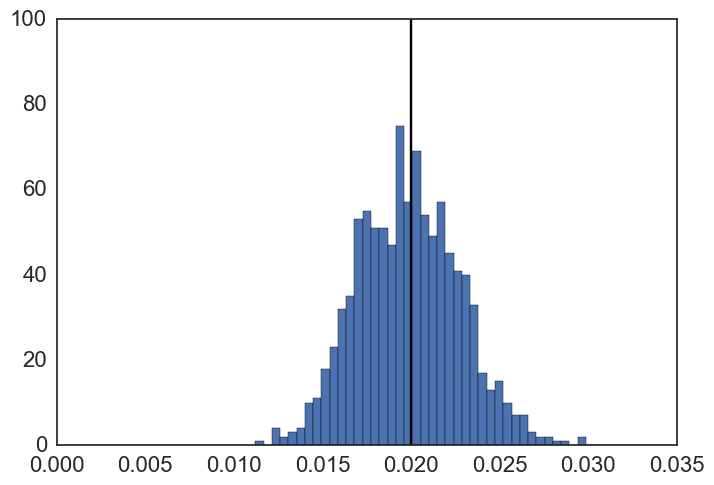

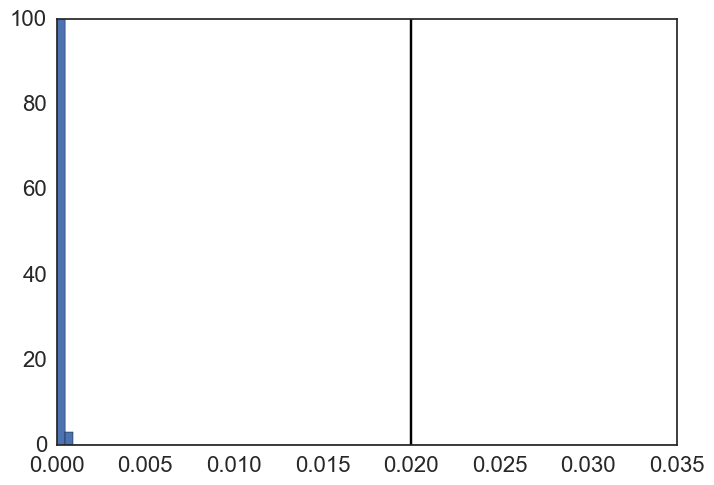

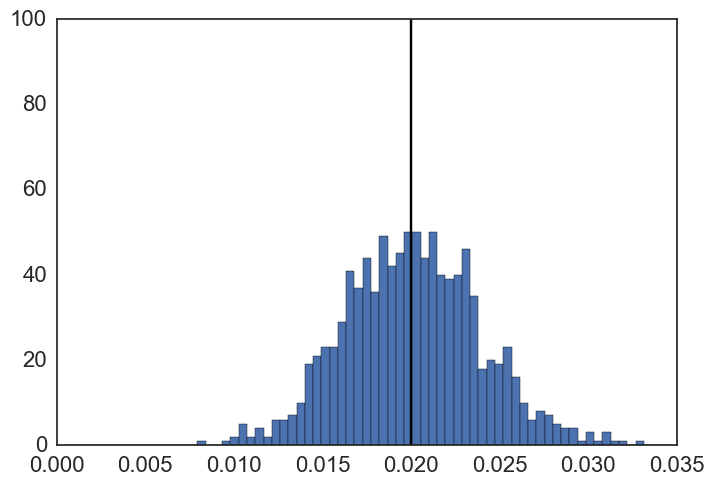

In [56]:
"""
predictions_hist(predictions[4], mp.lamda, 
                 "Convolutional Architecture - Multiple Output - ReLU", 
                 "Lambda",
                 min_edge = 0.004,
                 max_edge = 0.025,
                 y_lim = (0, 100),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-MultipleOutput-ReLU/");
"""


predictions_hist(df_mle['Lambda_0.02'].as_matrix(), mp.lamda, 
                 "Maximum Likelihood Estimation", 
                 "Lambda",
                 min_edge = 0,
                 max_edge = 0.035,
                 y_lim = (0, 100),
                 img_subdir = "/Images/Parameter-Prediction-Results/MLE/");

predictions_hist(df_mme['Lambda_0.02'].as_matrix(), mp.lamda, 
                 "Generalised Method of Moments Estimation", 
                 "Lambda",
                 min_edge = 0,
                 max_edge = 0.035,
                 y_lim = (0, 100),
                 img_subdir = "/Images/Parameter-Prediction-Results/MME/");

predictions_hist(df_profiling['Lambda_0.02'].as_matrix(), mp.lamda, 
                 "Likelihood Profiling (Honore)", 
                 "Lambda",
                 min_edge = 0,
                 max_edge = 0.035,
                 y_lim = (0, 100),
                 img_subdir = "/Images/Parameter-Prediction-Results/Profiling/");


predictions_hist(predictions_elu[4], mp.lamda, 
                 "Convolutional Architecture - Multiple Output - ELU", 
                 "Lambda",
                 min_edge = 0,
                 max_edge = 0.035,
                 y_lim = (0, 100),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-MultipleOutput-ELU/");

predictions_hist(predictions_ff[4], mp.lamda, 
                 "Fully Connected Architecture - Multiple Output - ELU", 
                 "Lambda",
                 min_edge = 0,
                 max_edge = 0.025,
                 y_lim = (0, 100),
                 img_subdir = "/Images/Parameter-Prediction-Results/FullyConnected-MultipleOutput-ELU/");

predictions_hist(single_param_predictions_lambda, mp.lamda, 
                 "Convolutional Architecture - Single Output - ELU", 
                 "Lambda",
                 min_edge = 0,
                 max_edge = 0.035,
                 y_lim = (0, 100),
                 img_subdir = "/Images/Parameter-Prediction-Results/ConvolutionalNN-SingleOutput/");